# import Statments

In [184]:
!pip install skfeature-chappers


In [185]:

!pip install eli5

In [186]:

!pip install shap

In [187]:
import pandas as pd                    #  data handling
import numpy as np                     #  numerical operations
import matplotlib.pyplot as plt        #  plotting
import seaborn as sns                  #  static data visualization
import plotly.express as px            #  interactive plots
import plotly.graph_objects as go
from scipy.signal import butter, filtfilt, iirnotch
import math
from scipy.stats import zscore
from scipy.stats import median_abs_deviation
import missingno as msno
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from skfeature.function.similarity_based import fisher_score
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    matthews_corrcoef,
    average_precision_score,
    confusion_matrix,
    precision_score,
    recall_score
)
from sklearn.feature_selection import SequentialFeatureSelector
from itertools import product
from sklearn.ensemble import RandomForestClassifier


'''
import warnings
warnings.filterwarnings('ignore')     # ignore warnings to keep output clean
'''


"\nimport warnings\nwarnings.filterwarnings('ignore')     # ignore warnings to keep output clean\n"

# Load Data

In [188]:
EMG_df = pd.read_excel(
    "/content/EMG Data NAAFH 3Ver2.xlsx",
    keep_default_na=True,
    na_values=['NA', 'N/A', '']   # Only these become NaN
)

# Keep "None" as text (not missing)
cols = ['comorbidities', 'medications', 'surgery_history','injury_type']

for c in cols:
    EMG_df[c] = EMG_df[c].fillna("None")

# Preview
EMG_df.head()



ID  age sex   BMI dominant_side affected_limb limb_temperature_c  \
0   1   42   M  26.9         Right    Left Elbow                 37   
1   2   41   F  33.7         Right    Left Wrist               35.8   
2   3   24   M  37.1         Right   Right Wrist               35.7   
3   4   52   M  26.4         Right   Right Wrist                 36   
4   5   47   M  25.9         Right   Right Wrist               35.7   

  affected_limb_dominance                injury_type time_since_injury_months  \
0            Non-dominant  Compression – Neuropraxia                        1   
1            Non-dominant    Traumatic – Neuropraxia                        5   
2                Dominant   Entrapment – Neurotmesis                       10   
3                Dominant  Compression – Neuropraxia                        6   
4                Dominant    Traumatic – Axonotmesis                       10   

     comorbidities             medications  \
0             None                    None   
1     Hypertension              Pregabalin   
2  Diabetes Type 2  Vitamin B12 supplement   
3  Diabetes Type 2                 Insulin   
4             None              Pregabalin   

                      surgery_history  \
0                                None   
1  Carpal Tunnel Release (Left wrist)   
2                                None   
3                                None   
4                                None   

                                             diagnosis  \
0  Ulnar neuropathy at elbow (Cubital Tunnel Syndrome)   
1  Median neuropathy at wrist (Carpal Tunnel Syndrome)   
2  Median neuropathy at wrist (Carpal Tunnel Syndrome)   
3  Median neuropathy at wrist (Carpal Tunnel Syndrome)   
4  Median neuropathy at wrist (Carpal Tunnel Syndrome)   

                muscle_name   side Electrode_Type Electrode_Depth  \
0      Flexor carpi ulnaris   Left         Needle             1.6   
1  Abductor pollicis brevis   Left         Needle             2.4   
2  Abductor pollicis brevis  Right         Needle             2.5   
3         Opponens pollicis  Right         Needle               1   
4  Abductor pollicis brevis  Right        Surface             0.5   

  Contraction_Level Insertional_Activity Positive_Sharp_Waves  Fibrillation  \
0              Weak            Increased         Present (2+)  Present (1+)   
1              Full     Mildly increased         Present (1+)  Present (1+)   
2         Very weak            Increased         Present (2+)  Present (1+)   
3              Weak            Increased         Present (1+)  Present (1+)   
4         Very weak            Increased         Present (1+)  Present (3+)   

  Fasciculation  MUAP_Amplitude (mV)  MUAP_Duration (ms) Recruitment_Pattern  \
0  Present (1+)                  3.3                 9.1             Reduced   
1        Absent                  5.2                 9.2             Reduced   
2  Present (1+)                  1.9                14.2    Severely reduced   
3  Present (1+)                  3.7                10.9             Reduced   
4  Present (2+)                  1.5                 9.0    Severely reduced   

   Polyphasic_Units Voluntary_Activation_Quality Severity_Label  
0                43                      Partial       Moderate  
1                23                       Normal           Mild  
2                61                      Minimal         Severe  
3                41                      Partial       Moderate  
4                35                      Minimal         Severe

# EDA

## Data Structure Understanding

In [189]:
print("Shape of the dataset:", EMG_df.shape)


Shape of the dataset: (238, 29)


In [190]:
print("Columns:", EMG_df.columns)


Columns: Index(['ID', 'age', 'sex', 'BMI', 'dominant_side', 'affected_limb',
       'limb_temperature_c', 'affected_limb_dominance', 'injury_type',
       'time_since_injury_months', 'comorbidities', 'medications',
       'surgery_history', 'diagnosis', 'muscle_name', 'side', 'Electrode_Type',
       'Electrode_Depth', 'Contraction_Level', 'Insertional_Activity',
       'Positive_Sharp_Waves', 'Fibrillation', 'Fasciculation',
       'MUAP_Amplitude (mV)', 'MUAP_Duration (ms)', 'Recruitment_Pattern',
       'Polyphasic_Units', 'Voluntary_Activation_Quality', 'Severity_Label'],
      dtype='object')


In [191]:
print("\nBasic statistics:\n", EMG_df.describe())


Basic statistics:
                ID         age         BMI  MUAP_Amplitude (mV)  \
count  238.000000  238.000000  238.000000           238.000000   
mean   119.500000   42.357143   27.261345             4.244958   
std     68.848868   11.929583    4.909031             1.476581   
min      1.000000   18.000000   18.000000             0.800000   
25%     60.250000   34.000000   23.625000             3.200000   
50%    119.500000   42.000000   26.800000             4.000000   
75%    178.750000   50.000000   30.850000             5.275000   
max    238.000000   77.000000   42.000000             9.000000   

       MUAP_Duration (ms)  Polyphasic_Units  
count          238.000000        238.000000  
mean             9.681092         30.428571  
std              1.920514         20.328763  
min              6.000000          0.000000  
25%              8.300000         12.000000  
50%              9.300000         27.500000  
75%             10.975000         46.000000  
max             1

In [192]:
# Data Info + Memory Usage

EMG_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            238 non-null    int64  
 1   age                           238 non-null    int64  
 2   sex                           238 non-null    object 
 3   BMI                           238 non-null    float64
 4   dominant_side                 238 non-null    object 
 5   affected_limb                 238 non-null    object 
 6   limb_temperature_c            238 non-null    object 
 7   affected_limb_dominance       238 non-null    object 
 8   injury_type                   238 non-null    object 
 9   time_since_injury_months      238 non-null    object 
 10  comorbidities                 238 non-null    object 
 11  medications                   238 non-null    object 
 12  surgery_history               238 non-null    object 
 13  diagn

In [193]:
#these are Numerical Features BUT beacuse of the Unknown values they considered as object

for col in ['limb_temperature_c', 'time_since_injury_months', 'Electrode_Depth']:
    print(col, EMG_df[col].unique())


limb_temperature_c [37 35.8 35.7 36 36.6 36.1 36.3 35.9 36.2 35.1 35.4 35.6 36.4 36.5 34.9
 36.7 35.5 'Unknown' 36.9 34.5 35.3 35.2 37.5 37.4 36.8 35 37.1 34.8 37.3]
time_since_injury_months [1 5 10 6 2 4 0 3 8 14 7 15 9 20 12 16 11 22 'Unknown' 13]
Electrode_Depth [1.6 2.4 2.5 1 0.5 2.3 1.8 1.4 1.7 1.3 2.1 2.7 1.1 2.2 1.5 1.2 2 3 2.6 2.8
 'Unknown' 1.9 2.9]


In [194]:
numeric_fix_cols = ['limb_temperature_c',
                    'time_since_injury_months',
                    'Electrode_Depth']

for col in numeric_fix_cols:
    # Create indicator column for missing values
    EMG_df[col + '_missing'] = EMG_df[col].eq('Unknown') | EMG_df[col].isna()

    # Replace "Unknown" with NaN
    EMG_df[col] = EMG_df[col].replace('Unknown', np.nan)

    # Convert column to numeric
    EMG_df[col] = pd.to_numeric(EMG_df[col], errors='coerce')

/tmp/ipython-input-1950857534.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  EMG_df[col] = EMG_df[col].replace('Unknown', np.nan)
/tmp/ipython-input-1950857534.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  EMG_df[col] = EMG_df[col].replace('Unknown', np.nan)
/tmp/ipython-input-1950857534.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.s

In [195]:
#Count numeric & categorical features

# Select numeric & categorical features
numeric_features = EMG_df.select_dtypes(include=['int64', 'float64']).drop(columns=['ID'])
categorical_features = EMG_df.select_dtypes(include=['object', 'category'])

# column counts
print("Number of Numeric features:", len(numeric_features.columns))
print("Number of Categorical features:", len(categorical_features.columns))

# column names
print("\nNumeric feature:")
print(list(numeric_features.columns))

print("\nCategorical feature:")
print(list(categorical_features.columns))


Number of Numeric features: 8
Number of Categorical features: 20

Numeric feature:
['age', 'BMI', 'limb_temperature_c', 'time_since_injury_months', 'Electrode_Depth', 'MUAP_Amplitude (mV)', 'MUAP_Duration (ms)', 'Polyphasic_Units']

Categorical feature:
['sex', 'dominant_side', 'affected_limb', 'affected_limb_dominance', 'injury_type', 'comorbidities', 'medications', 'surgery_history', 'diagnosis', 'muscle_name', 'side', 'Electrode_Type', 'Contraction_Level', 'Insertional_Activity', 'Positive_Sharp_Waves', 'Fibrillation', 'Fasciculation', 'Recruitment_Pattern', 'Voluntary_Activation_Quality', 'Severity_Label']


## Descriptive Summary Statistics

In [196]:
# Summary stats for all numeric features

numeric_cols = EMG_df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = numeric_cols.drop('ID')

EMG_df[numeric_cols].describe().T  # Transpose for readability

count       mean        std   min     25%   50%  \
age                       238.0  42.357143  11.929583  18.0  34.000  42.0   
BMI                       238.0  27.261345   4.909031  18.0  23.625  26.8   
limb_temperature_c        237.0  35.998734   0.554678  34.5  35.700  36.0   
time_since_injury_months  235.0   4.710638   4.355134   0.0   1.000   4.0   
Electrode_Depth           237.0   1.729958   0.759508   0.5   1.200   1.9   
MUAP_Amplitude (mV)       238.0   4.244958   1.476581   0.8   3.200   4.0   
MUAP_Duration (ms)        238.0   9.681092   1.920514   6.0   8.300   9.3   
Polyphasic_Units          238.0  30.428571  20.328763   0.0  12.000  27.5   

                             75%   max  
age                       50.000  77.0  
BMI                       30.850  42.0  
limb_temperature_c        36.300  37.5  
time_since_injury_months   7.000  22.0  
Electrode_Depth            2.300   3.0  
MUAP_Amplitude (mV)        5.275   9.0  
MUAP_Duration (ms)        10.975  16.0  
Polyphasic_Units          46.000  84.0

In [197]:
print( type(numeric_features))
print( type(numeric_cols) )

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.indexes.base.Index'>


## Target Label Distribution

In [198]:
print("Severity distribution:")
print(EMG_df['Severity_Label'].value_counts())


Severity distribution:
Severity_Label
Moderate    87
Mild        82
Normal      46
Severe      23
Name: count, dtype: int64


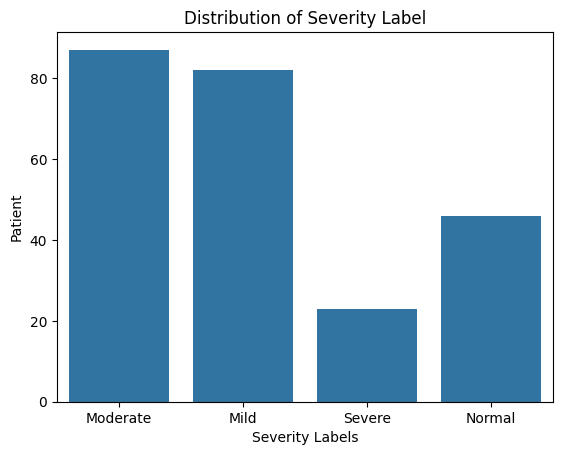

In [199]:
sns.countplot(data=EMG_df, x='Severity_Label')

plt.title('Distribution of Severity Label')
plt.xlabel("Severity Labels")
plt.ylabel("Patient")
plt.show()


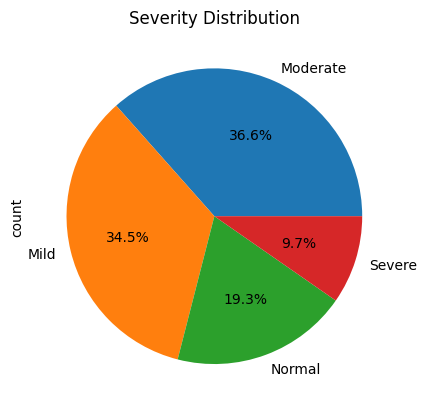

In [200]:
EMG_df['Severity_Label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Severity Distribution")
plt.show()


## Correlation Analysis

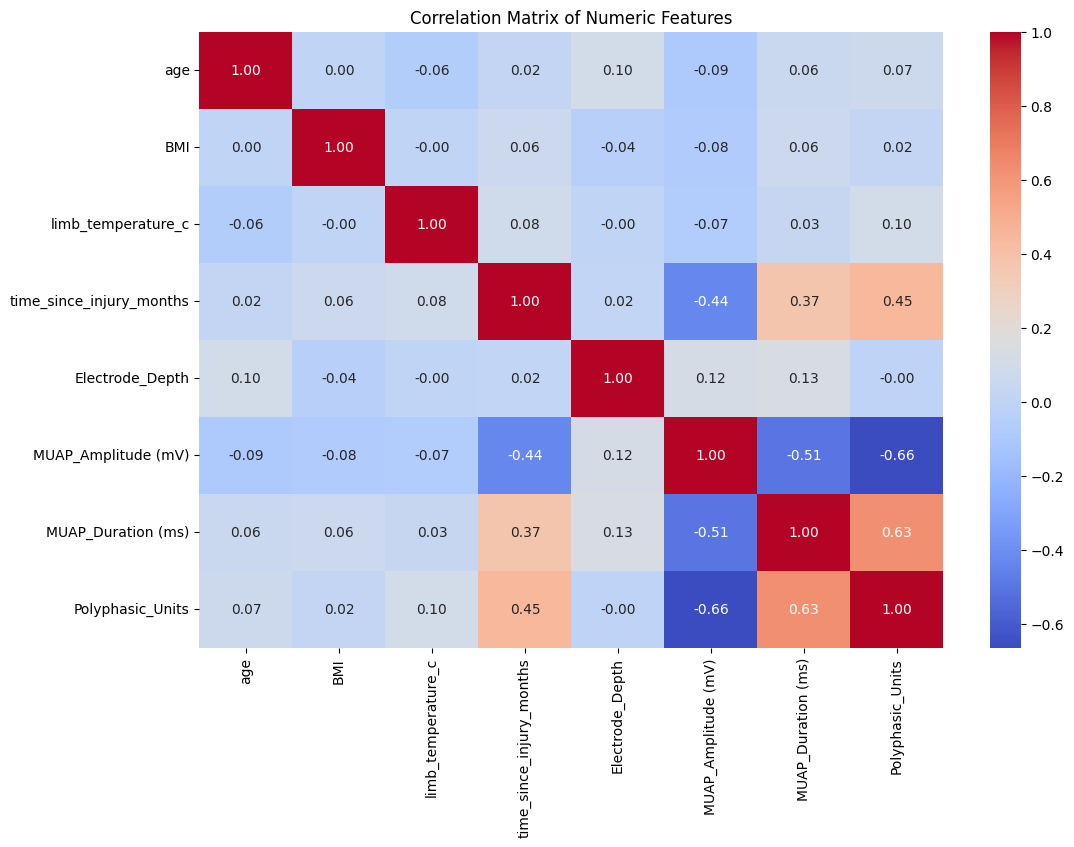

In [201]:
# Correlation matrix to detect collinear features

corr = EMG_df[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Features")
plt.show()


## Distribution of Each EMG Feature

### Numarical Features Distribution

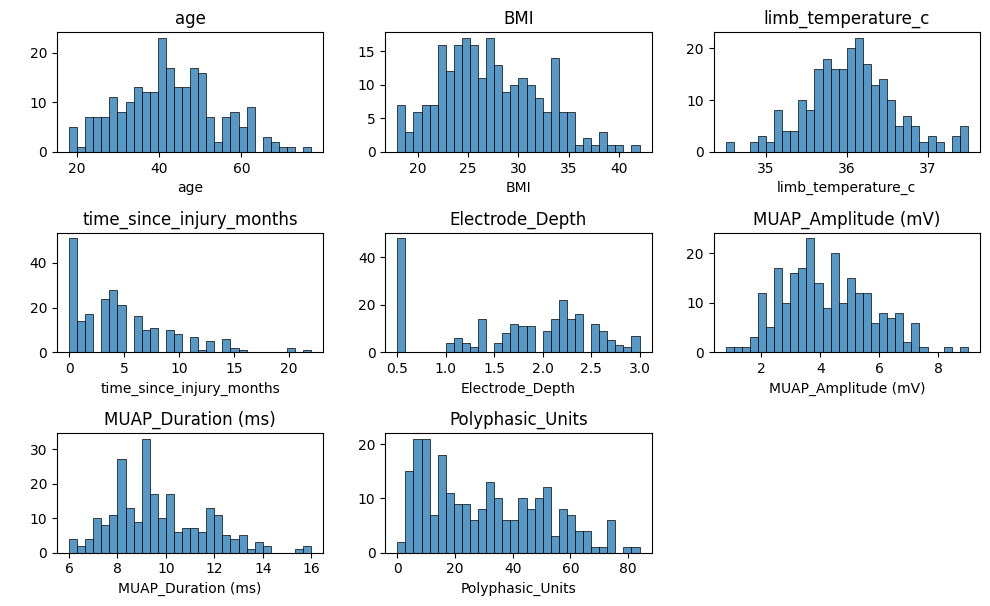

In [202]:
# number of charts per row
cols = 3

# round up the number of rows ; Ensures enough rows to display all features.
rows = math.ceil( len(numeric_features) / cols)

# Create Creates a new figure for all subplots ( witdh,height  )
plt.figure(figsize=(10, rows * 2))


for i, col in enumerate(numeric_features, 1):
    #Creates the i-th subplot in a grid of rows × cols.
    plt.subplot(rows, cols, i)

    # draws histogram + dropna() removes missing values before plottin + splits the data range into 30 buckets +  no density curve
    sns.histplot(EMG_df[col].dropna(), bins=30, kde=False)
    plt.title(f'{col}')
    plt.xlabel(col, fontsize=10)
    plt.ylabel(' ', fontsize=10)

plt.tight_layout()
plt.show()


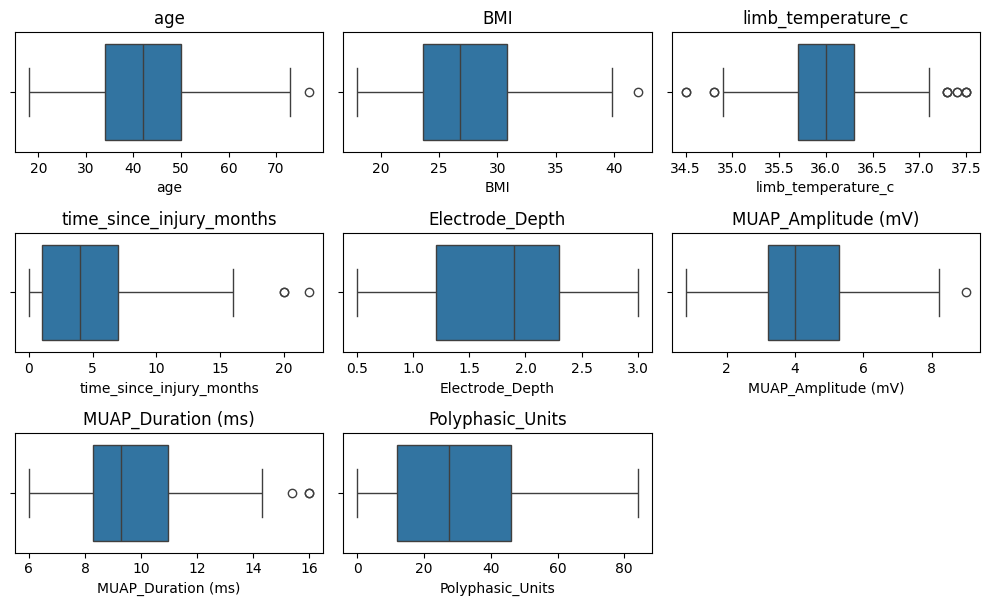

In [203]:
#  Boxplot by Nerve or Severity

plt.figure(figsize=(10, rows * 2))

for i, col in enumerate(numeric_features, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=EMG_df[col].dropna())
    plt.title(f'{col}')
    plt.xlabel(col, fontsize=10)

plt.tight_layout()
plt.show()


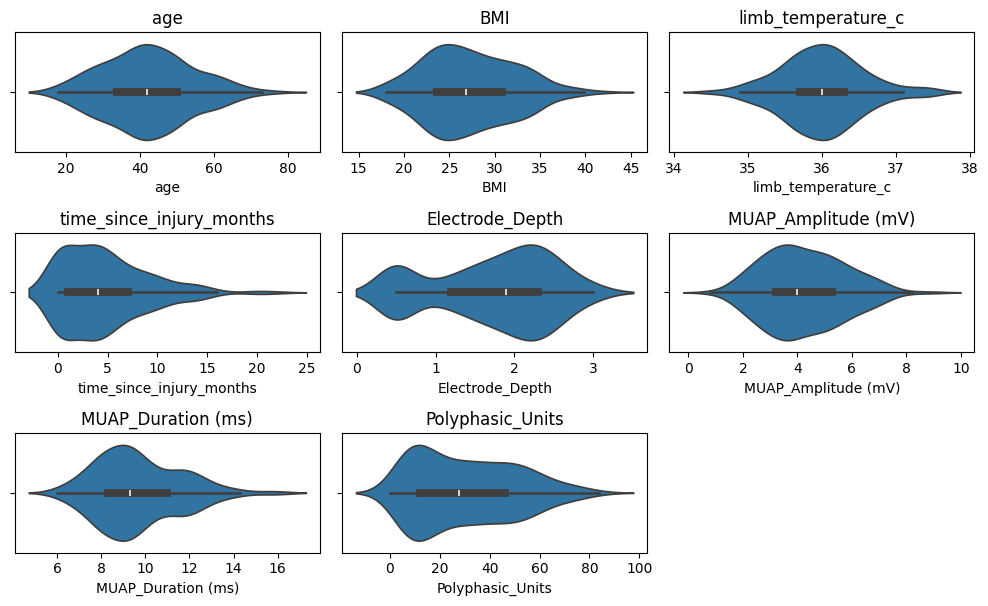

In [204]:
#Violin Plot
plt.figure(figsize=(10, rows * 2))

for i, col in enumerate(numeric_features, 1):
    plt.subplot(rows, cols, i)
    sns.violinplot(x=EMG_df[col].dropna())
    plt.title(f'{col}')
    plt.xlabel(col, fontsize=10)

plt.tight_layout()
plt.show()


### Catagorical Features Distribution

/tmp/ipython-input-3716299389.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=EMG_df, x=col, palette='Set2')
/tmp/ipython-input-3716299389.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=EMG_df, x=col, palette='Set2')
/tmp/ipython-input-3716299389.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=EMG_df, x=col, palette='Set2')
/tmp/ipython-input-3716299389.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `

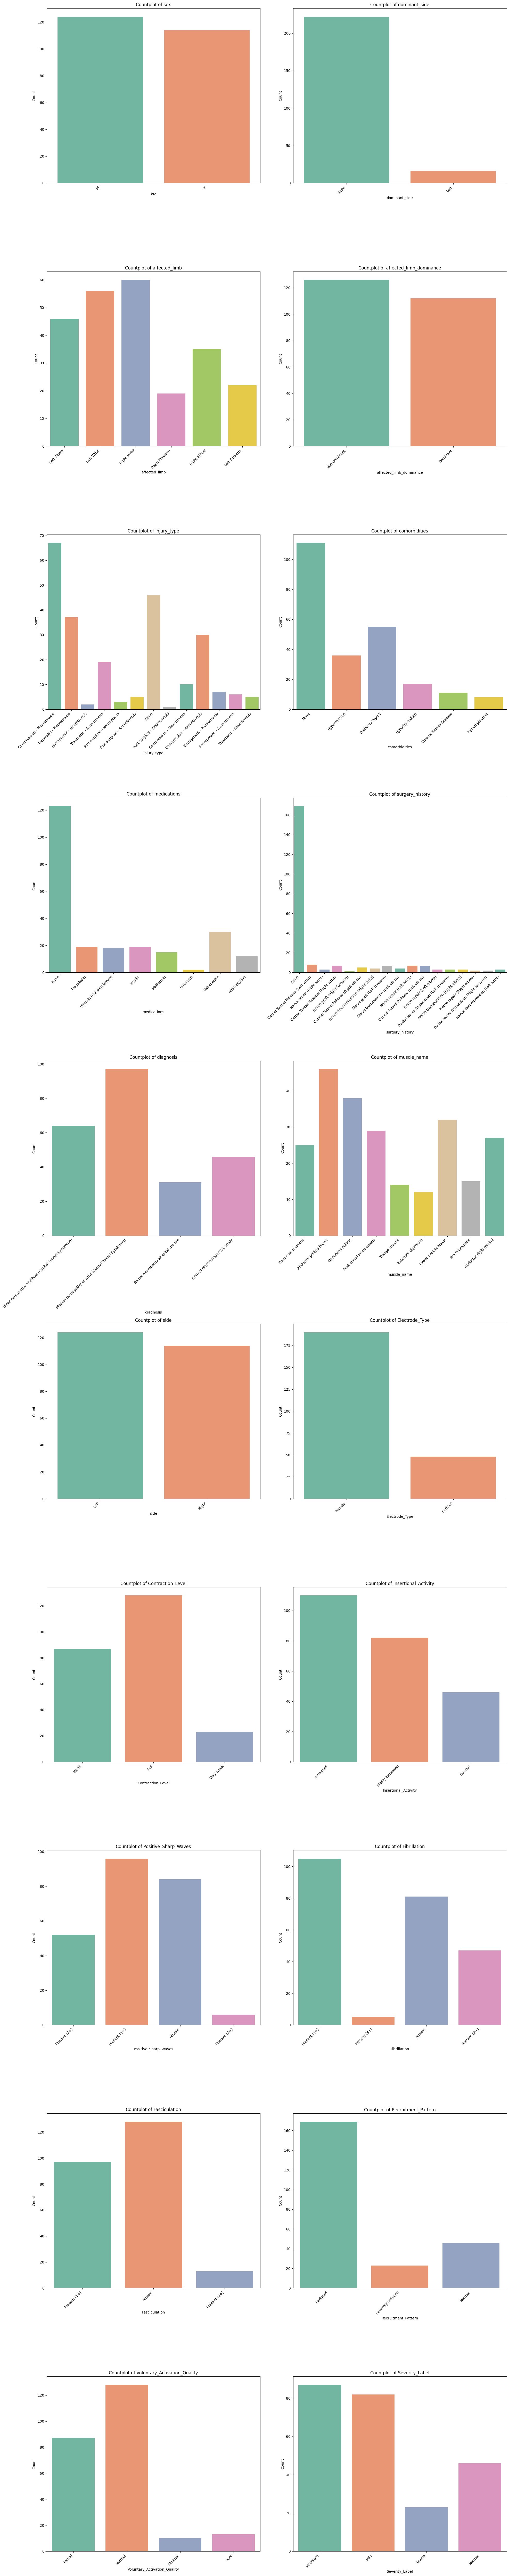

In [205]:
# Count Plot

# Select categorical columns
categorical_cols = EMG_df.select_dtypes(include=['object', 'category']).columns

# Number of categorical features
n_cat = len(categorical_cols)

# Layout
cols = 2   # number of plots per row
rows = math.ceil(n_cat / cols)

# Create figure
plt.figure(figsize=(20, rows * 10))

# Loop for subplots
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(rows, cols, i)
    sns.countplot(data=EMG_df, x=col, palette='Set2')
    plt.title(f'Countplot of {col}', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


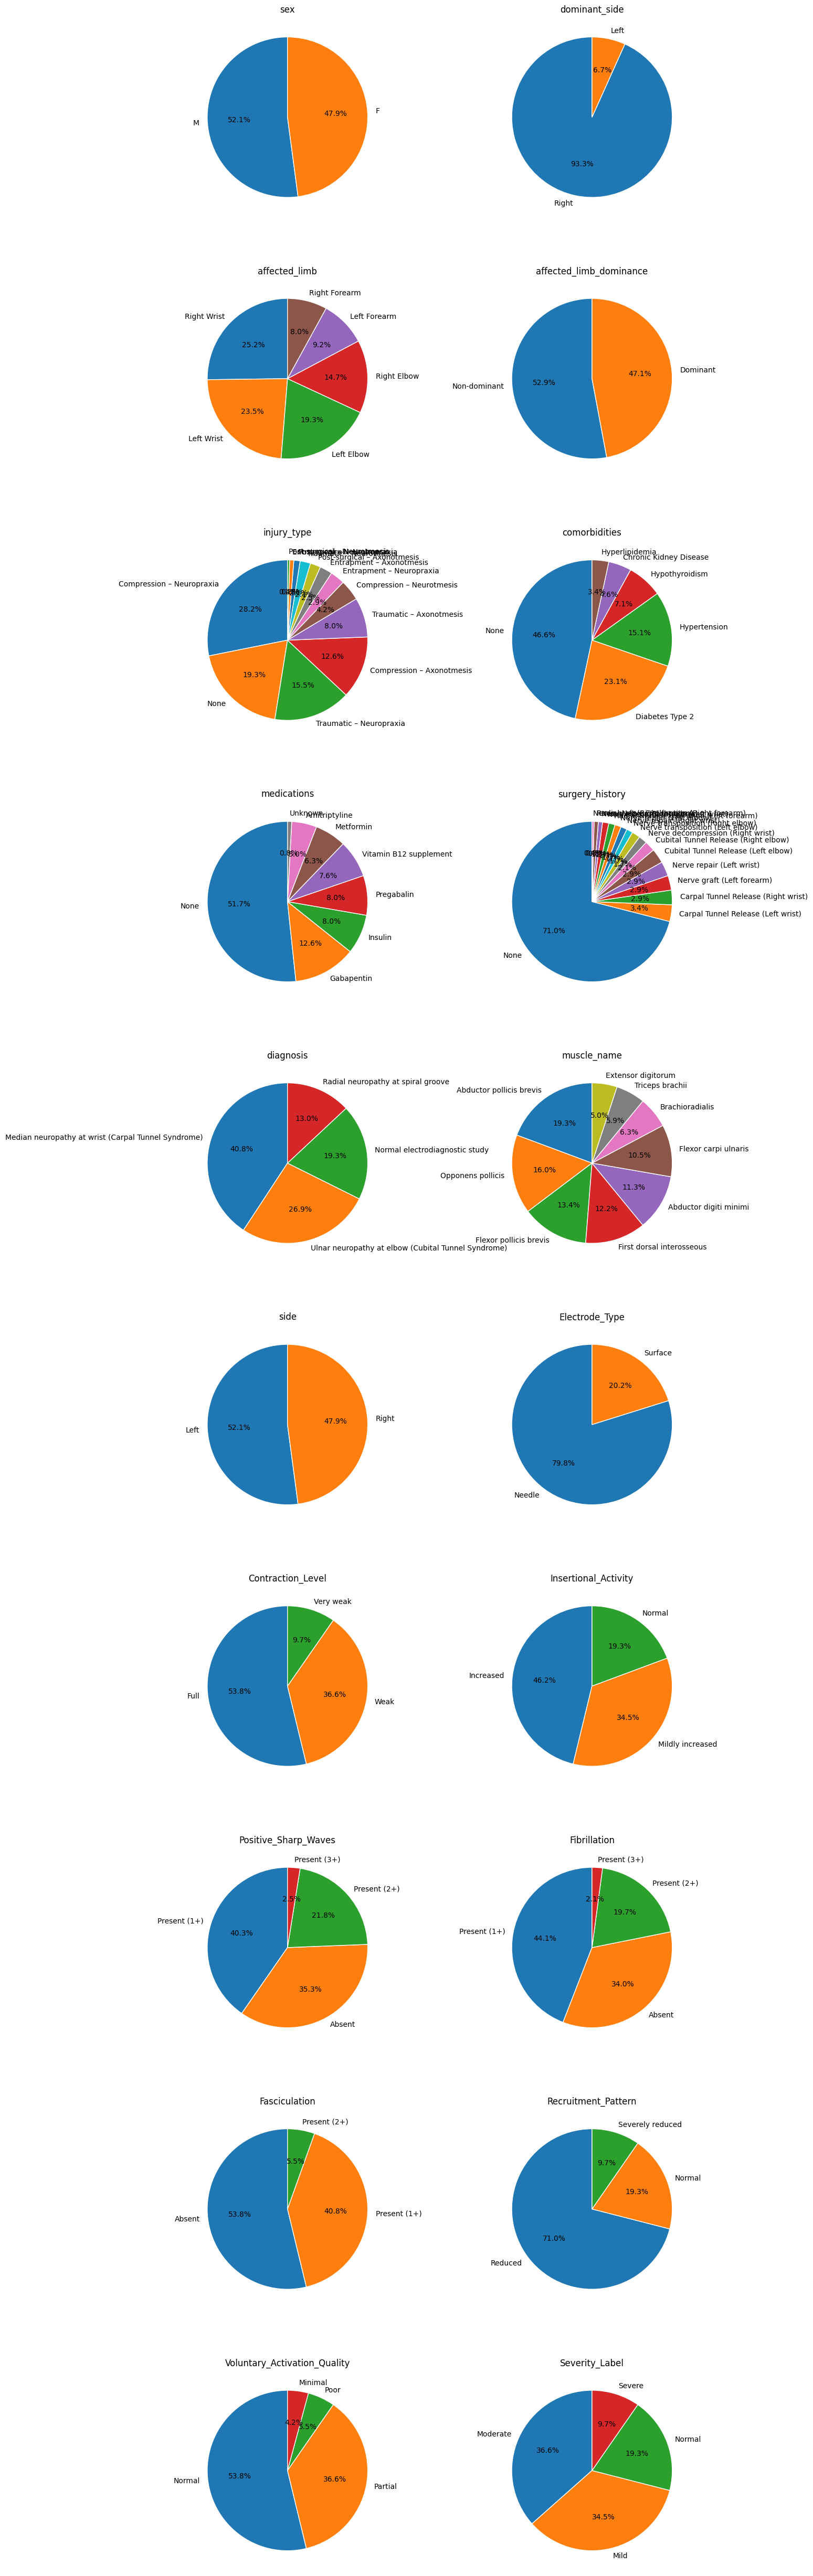

In [206]:
# Pie chart

# Select categorical columns
categorical_cols = EMG_df.select_dtypes(include=['object', 'category']).columns

# Number of categorical features
n_cat = len(categorical_cols)

# Subplot layout
cols = 2
rows = math.ceil(n_cat / cols)

# Create the figure
plt.figure(figsize=(14, rows * 5))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(rows, cols, i)

    # Get counts
    data = EMG_df[col].value_counts()

    # Pie chart
    plt.pie(
        data.values,
        labels=data.index,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 10},
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
    )

    plt.title(f'{col}', fontsize=12)

plt.tight_layout()
plt.show()


## Missing Values

In [207]:
print("Missing values per column:\n", EMG_df.isnull().sum()) #Nan None


Missing values per column:
 ID                                  0
age                                 0
sex                                 0
BMI                                 0
dominant_side                       0
affected_limb                       0
limb_temperature_c                  1
affected_limb_dominance             0
injury_type                         0
time_since_injury_months            3
comorbidities                       0
medications                         0
surgery_history                     0
diagnosis                           0
muscle_name                         0
side                                0
Electrode_Type                      0
Electrode_Depth                     1
Contraction_Level                   0
Insertional_Activity                0
Positive_Sharp_Waves                0
Fibrillation                        0
Fasciculation                       0
MUAP_Amplitude (mV)                 0
MUAP_Duration (ms)                  0
Recruitment_Pattern   

In [208]:
# Missing values percentage per column
missing_percent = (EMG_df.isnull().sum() / len(EMG_df)) * 100

print("Missing Values Percentage (%):\n")
print(missing_percent.sort_values(ascending=False))

Missing Values Percentage (%):

time_since_injury_months            1.260504
limb_temperature_c                  0.420168
Electrode_Depth                     0.420168
sex                                 0.000000
BMI                                 0.000000
dominant_side                       0.000000
affected_limb                       0.000000
ID                                  0.000000
affected_limb_dominance             0.000000
injury_type                         0.000000
comorbidities                       0.000000
medications                         0.000000
surgery_history                     0.000000
diagnosis                           0.000000
muscle_name                         0.000000
age                                 0.000000
side                                0.000000
Electrode_Type                      0.000000
Contraction_Level                   0.000000
Insertional_Activity                0.000000
Positive_Sharp_Waves                0.000000
Fibrillation           

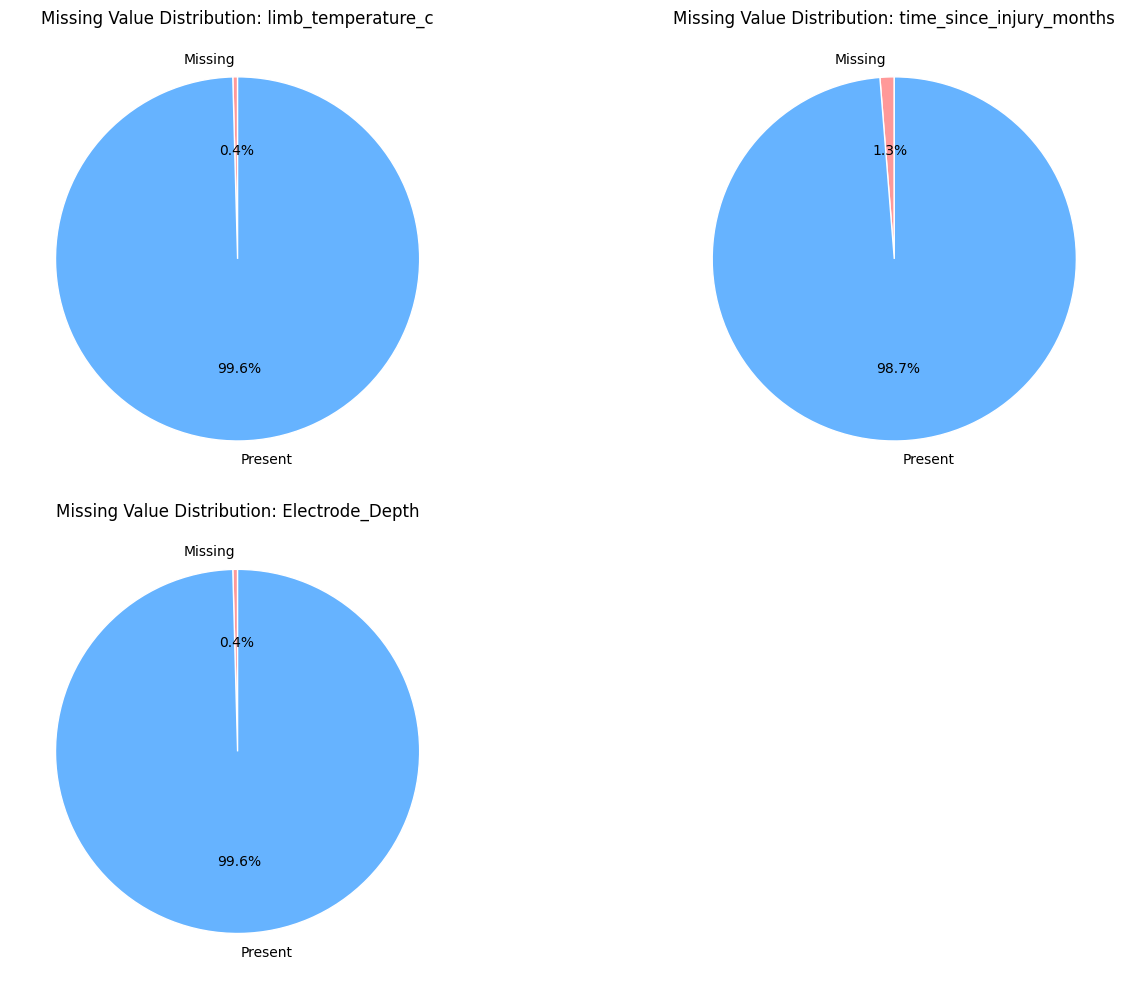

In [209]:
#  Pie chart for Missing Values

# 1) Missing values percentage per column
missing_percent = (EMG_df.isnull().sum() / len(EMG_df)) * 100

# 2) Select only features that actually have missing values
missing_features = missing_percent[missing_percent > 0]


# 3) Subplot layout
n_features = len(missing_features)
cols = 2
rows = math.ceil(n_features / cols)

# 4) Create figure
plt.figure(figsize=(14, rows * 5))

# 5) Loop & draw pie chart for each feature
for i, col in enumerate(missing_features.index, 1):
    plt.subplot(rows, cols, i)

    # Values: missing vs present
    missing_count = EMG_df[col].isnull().sum()
    present_count = len(EMG_df) - missing_count

    plt.pie(
        [missing_count, present_count],
        labels=['Missing', 'Present'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#ff9999', '#66b3ff'],
        textprops={'fontsize': 10},
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
    )

    plt.title(f'Missing Value Distribution: {col}', fontsize=12)

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

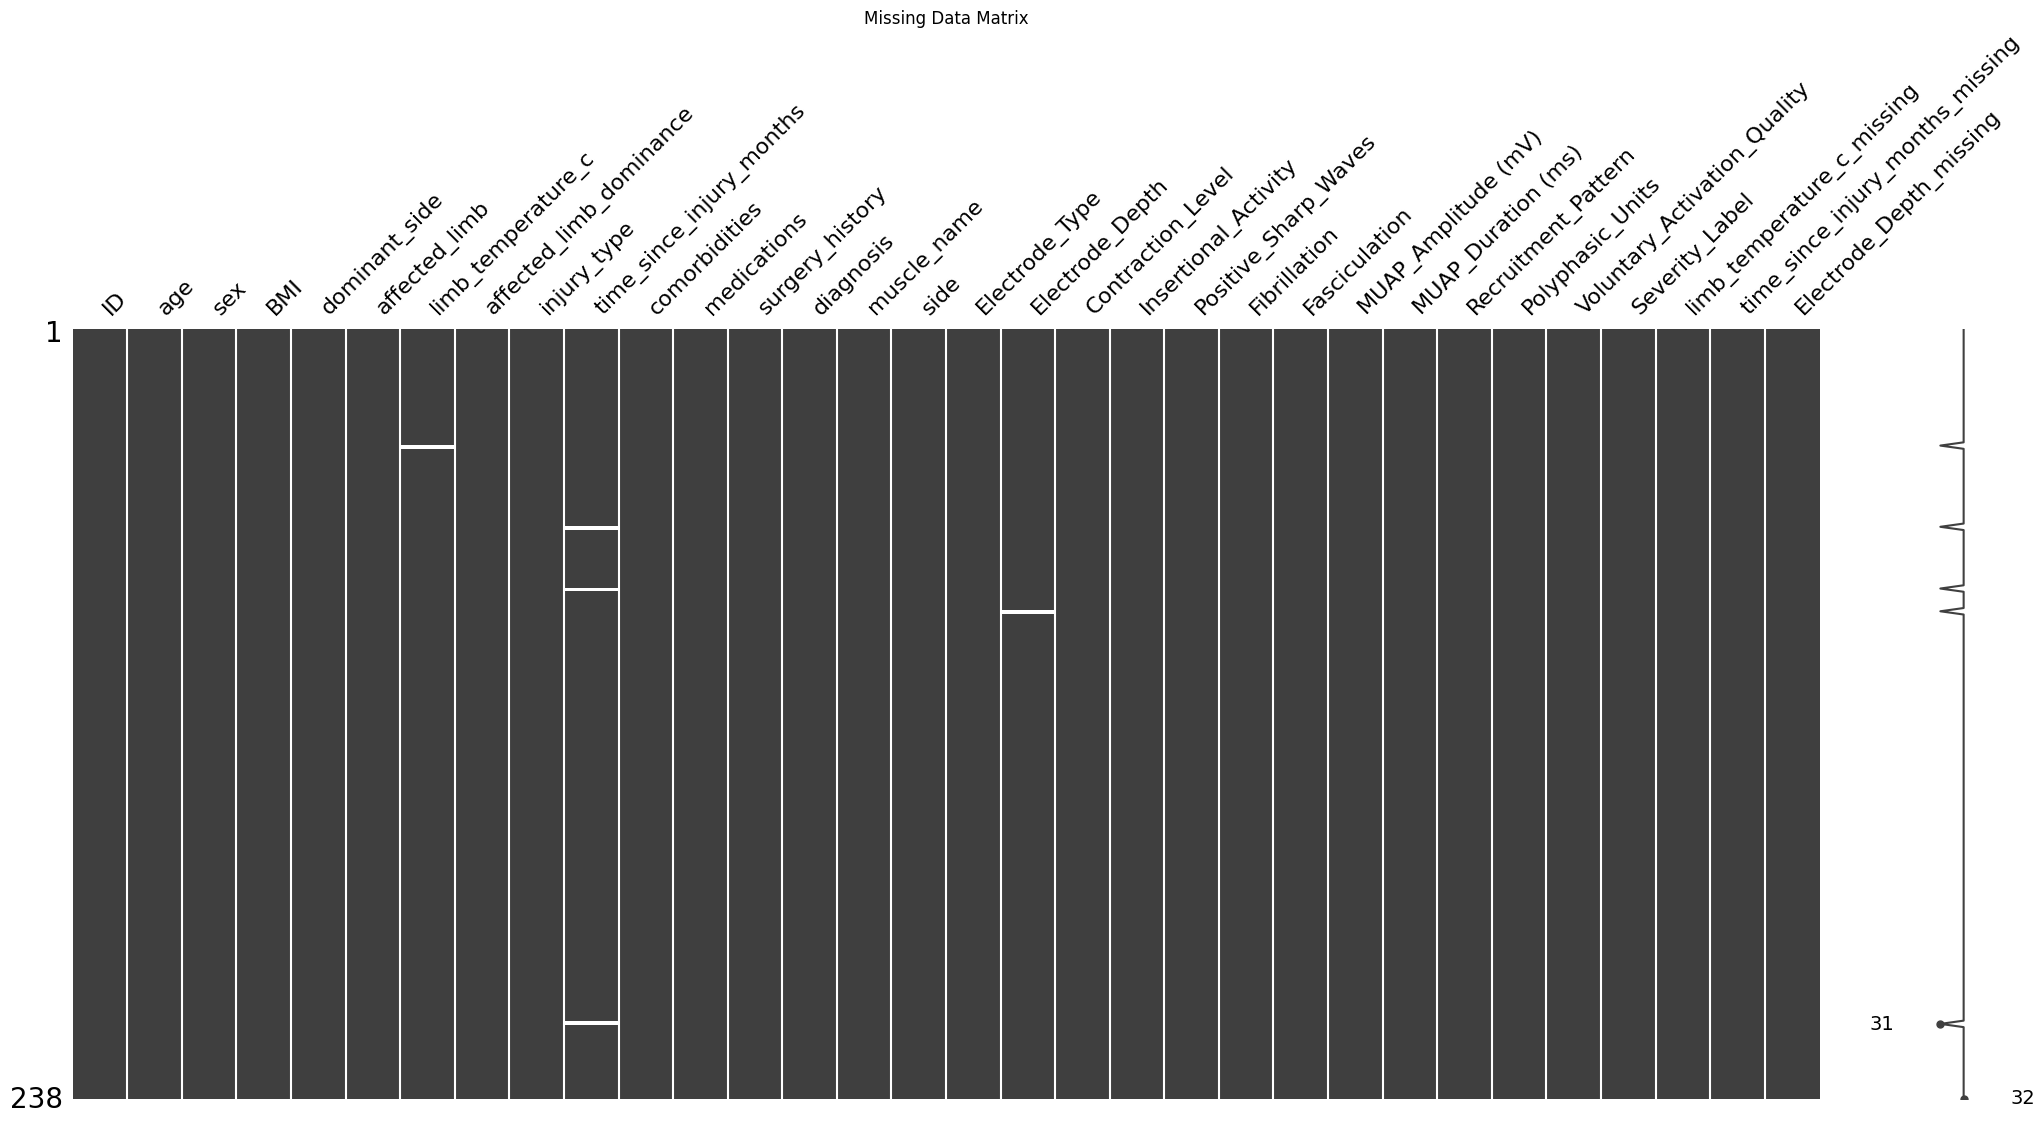

In [210]:
# Missingno

plt.figure(figsize=(12, 6))
msno.matrix(EMG_df)
plt.title("Missing Data Matrix")
plt.show()


## Duplicates Recoreds


In [211]:
dup_rows = EMG_df.duplicated().sum()
print("\nNumber of Fully Duplicated rows:", dup_rows)


Number of Fully Duplicated rows: 0


## Detecting Messy Format

In [212]:
# Detect Non-Numeric Characters Inside Numeric Columns

for col in EMG_df.select_dtypes(include='object'):
    # Check if column is supposed to be numeric
    try:
        EMG_df[col].astype(float)
        print(f"POSSIBLE WRONG FORMAT → {col}: contains numeric-like strings")
    except:
        pass


In [213]:
# Detect Leading / Trailing Spaces

for col in EMG_df.select_dtypes(include='object'):
    EMG_df[col] = EMG_df[col].astype(str)
    if EMG_df[col].str.contains(r'^\s+|\s+$').any():
        print(f"WARNING: Spaces in {col}")


In [214]:
# Detect Mixed Formats

for col in EMG_df.select_dtypes(include='object'):
    print(f"\nUnique values in {col}:")
    print(EMG_df[col].unique())



Unique values in sex:
['M' 'F']

Unique values in dominant_side:
['Right' 'Left']

Unique values in affected_limb:
['Left Elbow' 'Left Wrist' 'Right Wrist' 'Right Forearm' 'Right Elbow'
 'Left Forearm']

Unique values in affected_limb_dominance:
['Non-dominant' 'Dominant']

Unique values in injury_type:
['Compression – Neuropraxia' 'Traumatic – Neuropraxia'
 'Entrapment – Neurotmesis' 'Traumatic – Axonotmesis'
 'Post-surgical – Neuropraxia' 'Post-surgical – Axonotmesis' 'None'
 'Post-surgical – Neurotmesis' 'Compression – Neurotmesis'
 'Compression – Axonotmesis' 'Entrapment – Neuropraxia'
 'Entrapment – Axonotmesis' 'Traumatic – Neurotmesis']

Unique values in comorbidities:
['None' 'Hypertension' 'Diabetes Type 2' 'Hypothyroidism'
 'Chronic Kidney Disease' 'Hyperlipidemia']

Unique values in medications:
['None' 'Pregabalin' 'Vitamin B12 supplement' 'Insulin' 'Metformin'
 'Unknown' 'Gabapentin' 'Amitriptyline']

Unique values in surgery_history:
['None' 'Carpal Tunnel Release (Left 

In [215]:
# Detect Unexpected / Invalid Categories

for col in EMG_df.select_dtypes(include='object'):
    print(f"\n{col} → unique values:")
    print(EMG_df[col].value_counts(dropna=False))



sex → unique values:
sex
M    124
F    114
Name: count, dtype: int64

dominant_side → unique values:
dominant_side
Right    222
Left      16
Name: count, dtype: int64

affected_limb → unique values:
affected_limb
Right Wrist      60
Left Wrist       56
Left Elbow       46
Right Elbow      35
Left Forearm     22
Right Forearm    19
Name: count, dtype: int64

affected_limb_dominance → unique values:
affected_limb_dominance
Non-dominant    126
Dominant        112
Name: count, dtype: int64

injury_type → unique values:
injury_type
Compression – Neuropraxia      67
None                           46
Traumatic – Neuropraxia        37
Compression – Axonotmesis      30
Traumatic – Axonotmesis        19
Compression – Neurotmesis      10
Entrapment – Neuropraxia        7
Entrapment – Axonotmesis        6
Post-surgical – Axonotmesis     5
Traumatic – Neurotmesis         5
Post-surgical – Neuropraxia     3
Entrapment – Neurotmesis        2
Post-surgical – Neurotmesis     1
Name: count, dtype: int6

In [216]:
# Detect Columns with Mixed Types

for col in EMG_df.columns:
    types = EMG_df[col].apply(type).value_counts()
    if len(types) > 1:
        print(f"Mixed types in {col}: {types}")


In [217]:
# Detect Out-of-range Values (Medical Logic Rules)

print((EMG_df["age"] < 0).sum(), "negative ages")
print((EMG_df["limb_temperature_c"] > 45).sum(), "invalid temperatures")
print((EMG_df["MUAP_Amplitude (mV)"] < 0).sum(), "negative EMG amplitude")


0 negative ages
0 invalid temperatures
0 negative EMG amplitude


In [218]:
# Detect Symbols or Patterns in Categorical Columns

import re

for col in EMG_df.select_dtypes(include='object'):
    if EMG_df[col].str.contains(r'\(|\)|\+|\-').any():
        print(f"Possible encoded scale in {col}")


Possible encoded scale in affected_limb_dominance
Possible encoded scale in injury_type
Possible encoded scale in surgery_history
Possible encoded scale in diagnosis
Possible encoded scale in Positive_Sharp_Waves
Possible encoded scale in Fibrillation
Possible encoded scale in Fasciculation


## Detecting Outliers



### IQR

In [219]:
'''
  - Fourmla:
        IQR = Q3 − Q1
        [Q1−1.5× IQR , Q3+1.5×IQR]
'''

Q1 = EMG_df[numeric_cols].quantile(0.25)
Q3 = EMG_df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Boolean mask of outliers (True = outlier)
outlier_mask = (EMG_df[numeric_cols] < lower_bound) | (EMG_df[numeric_cols] > upper_bound)

# Number of rows with at least one outlier
print("IQR Outlier Rows:", outlier_mask.any(axis=1).sum())

# List rows + feature names
for idx in outlier_mask.any(axis=1).index[outlier_mask.any(axis=1)]:
    feats = list(outlier_mask.columns[outlier_mask.loc[idx]])
    print(f"Row {idx}: {feats}")


IQR Outlier Rows: 21
Row 27: ['time_since_injury_months']
Row 40: ['limb_temperature_c']
Row 49: ['BMI']
Row 52: ['time_since_injury_months']
Row 74: ['MUAP_Duration (ms)']
Row 83: ['limb_temperature_c']
Row 96: ['MUAP_Duration (ms)']
Row 104: ['limb_temperature_c']
Row 131: ['MUAP_Duration (ms)']
Row 143: ['time_since_injury_months']
Row 152: ['limb_temperature_c']
Row 163: ['MUAP_Amplitude (mV)']
Row 164: ['limb_temperature_c']
Row 177: ['age']
Row 180: ['limb_temperature_c']
Row 187: ['limb_temperature_c']
Row 192: ['limb_temperature_c']
Row 196: ['limb_temperature_c']
Row 197: ['limb_temperature_c']
Row 198: ['limb_temperature_c']
Row 228: ['limb_temperature_c']


### MAD:  Median Absolute Deviation




In [220]:
'''
  MAD: Median Absolute Deviation (Robust Z-score)

  Why MAD?
  - Z-score uses mean and std → very sensitive to outliers
  - MAD uses median → resistant to extreme values

  - formula:
       Z_robust = 0.6745 * (x - median) / MAD

  - Outlier If:
       |Z_robust| > threshold

  - Common threshold = 3.5 (more robust than Z-score=3)
'''

threshold = 3.5

# Compute median and MAD per numeric feature
median_vals = EMG_df[numeric_cols].median()
mad_vals = EMG_df[numeric_cols].apply(median_abs_deviation)

# Smoothing: Avoid division by zero by replacing MAD=0 with a tiny value
mad_vals = mad_vals.replace(0, 1e-9)

# Compute Robust Z-score
df_mad = 0.6745 * (EMG_df[numeric_cols] - median_vals) / mad_vals

# Boolean mask of outliers
outlier_flags = df_mad.abs() > threshold

# Count outliers per row
outlier_mask = outlier_flags.sum(axis=1)


# Results
print(f"Rows with > {threshold} MAD deviations:", (outlier_mask > 0).sum())
print("\n=== Outlier Rows and Feature Names ===\n")

for idx, count in outlier_mask[outlier_mask > 0].items():
    features_with_outliers = list(outlier_flags.columns[outlier_flags.loc[idx]])
    print(f"Row {idx}: {features_with_outliers}")


Rows with > 3.5 MAD deviations: 2

=== Outlier Rows and Feature Names ===

Row 74: ['MUAP_Duration (ms)']
Row 131: ['MUAP_Duration (ms)']


### Z-Score

In [221]:
'''
  in Gaussian Normal Distribution:
  - 68% of data  within   +-1 std
  - 95% is within         +- 2 std
  - 99.7% is within       += 3 std   ;  Anything beyond ±3 std is Outli

'''
#  Z-score threshold
std = 2

# Compute Z-scores only for numeric columns
df_z = EMG_df[numeric_cols].apply(zscore)


# Find outliers per row (True/False mask)
outlier_flags = df_z.abs() > std


# Count number of outliers per row
outlier_mask = outlier_flags.sum(axis=1)

# results
print("Rows with >",std," Standard Deviations:  ", (outlier_mask > 0).sum())
print("\n=== Outlier Rows and Feature Names ===\n")
for idx, count in outlier_mask[outlier_mask > 0].items():
    features_with_outliers = list(outlier_flags.columns[outlier_flags.loc[idx]])
    print(f"Row {idx}: {features_with_outliers}")

Rows with > 2  Standard Deviations:   39

=== Outlier Rows and Feature Names ===

Row 2: ['BMI', 'MUAP_Duration (ms)']
Row 9: ['BMI']
Row 13: ['MUAP_Amplitude (mV)']
Row 18: ['age']
Row 25: ['BMI']
Row 32: ['age']
Row 36: ['Polyphasic_Units']
Row 49: ['BMI']
Row 59: ['Polyphasic_Units']
Row 64: ['MUAP_Amplitude (mV)']
Row 66: ['BMI']
Row 73: ['MUAP_Amplitude (mV)']
Row 74: ['MUAP_Duration (ms)']
Row 81: ['Polyphasic_Units']
Row 96: ['MUAP_Duration (ms)']
Row 111: ['MUAP_Amplitude (mV)']
Row 124: ['age']
Row 131: ['MUAP_Duration (ms)']
Row 133: ['age']
Row 137: ['Polyphasic_Units']
Row 143: ['age']
Row 148: ['MUAP_Duration (ms)']
Row 162: ['MUAP_Duration (ms)']
Row 163: ['MUAP_Amplitude (mV)']
Row 170: ['age']
Row 172: ['MUAP_Duration (ms)']
Row 177: ['age']
Row 191: ['MUAP_Amplitude (mV)', 'Polyphasic_Units']
Row 194: ['BMI']
Row 202: ['Polyphasic_Units']
Row 204: ['BMI']
Row 211: ['BMI', 'MUAP_Amplitude (mV)']
Row 214: ['age']
Row 216: ['age']
Row 224: ['age']
Row 231: ['age']
Row 232

# Preprocessing

## Handle Missing Values

In [222]:
# Loop through each numeric column that requires fixing missing values
for col in numeric_fix_cols:

    # Compute the median of the current column
    median_val = EMG_df[col].median()

    # Replace all NaN values in this column with the computed median
    EMG_df[col].fillna(median_val, inplace=True)



/tmp/ipython-input-49927088.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  EMG_df[col].fillna(median_val, inplace=True)


In [223]:
print("Missing values per column:\n", EMG_df.isnull().sum()) #Nan None


Missing values per column:
 ID                                  0
age                                 0
sex                                 0
BMI                                 0
dominant_side                       0
affected_limb                       0
limb_temperature_c                  0
affected_limb_dominance             0
injury_type                         0
time_since_injury_months            0
comorbidities                       0
medications                         0
surgery_history                     0
diagnosis                           0
muscle_name                         0
side                                0
Electrode_Type                      0
Electrode_Depth                     0
Contraction_Level                   0
Insertional_Activity                0
Positive_Sharp_Waves                0
Fibrillation                        0
Fasciculation                       0
MUAP_Amplitude (mV)                 0
MUAP_Duration (ms)                  0
Recruitment_Pattern   

In [224]:
# Target columns
target_cols = ['Severity_Label']

# Reorder: (all other columns) + (target columns)
EMG_df = EMG_df[[col for col in EMG_df.columns if col not in target_cols] + target_cols]

In [225]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

EMG_df.head()

ID  age sex   BMI dominant_side affected_limb  limb_temperature_c  \
0   1   42   M  26.9         Right    Left Elbow                37.0   
1   2   41   F  33.7         Right    Left Wrist                35.8   
2   3   24   M  37.1         Right   Right Wrist                35.7   
3   4   52   M  26.4         Right   Right Wrist                36.0   
4   5   47   M  25.9         Right   Right Wrist                35.7   

  affected_limb_dominance                injury_type  \
0            Non-dominant  Compression – Neuropraxia   
1            Non-dominant    Traumatic – Neuropraxia   
2                Dominant   Entrapment – Neurotmesis   
3                Dominant  Compression – Neuropraxia   
4                Dominant    Traumatic – Axonotmesis   

   time_since_injury_months    comorbidities             medications  \
0                       1.0             None                    None   
1                       5.0     Hypertension              Pregabalin   
2                      10.0  Diabetes Type 2  Vitamin B12 supplement   
3                       6.0  Diabetes Type 2                 Insulin   
4                      10.0             None              Pregabalin   

                      surgery_history  \
0                                None   
1  Carpal Tunnel Release (Left wrist)   
2                                None   
3                                None   
4                                None   

                                             diagnosis  \
0  Ulnar neuropathy at elbow (Cubital Tunnel Syndrome)   
1  Median neuropathy at wrist (Carpal Tunnel Syndrome)   
2  Median neuropathy at wrist (Carpal Tunnel Syndrome)   
3  Median neuropathy at wrist (Carpal Tunnel Syndrome)   
4  Median neuropathy at wrist (Carpal Tunnel Syndrome)   

                muscle_name   side Electrode_Type  Electrode_Depth  \
0      Flexor carpi ulnaris   Left         Needle              1.6   
1  Abductor pollicis brevis   Left         Needle              2.4   
2  Abductor pollicis brevis  Right         Needle              2.5   
3         Opponens pollicis  Right         Needle              1.0   
4  Abductor pollicis brevis  Right        Surface              0.5   

  Contraction_Level Insertional_Activity Positive_Sharp_Waves  Fibrillation  \
0              Weak            Increased         Present (2+)  Present (1+)   
1              Full     Mildly increased         Present (1+)  Present (1+)   
2         Very weak            Increased         Present (2+)  Present (1+)   
3              Weak            Increased         Present (1+)  Present (1+)   
4         Very weak            Increased         Present (1+)  Present (3+)   

  Fasciculation  MUAP_Amplitude (mV)  MUAP_Duration (ms) Recruitment_Pattern  \
0  Present (1+)                  3.3                 9.1             Reduced   
1        Absent                  5.2                 9.2             Reduced   
2  Present (1+)                  1.9                14.2    Severely reduced   
3  Present (1+)                  3.7                10.9             Reduced   
4  Present (2+)                  1.5                 9.0    Severely reduced   

   Polyphasic_Units Voluntary_Activation_Quality  limb_temperature_c_missing  \
0                43                      Partial                       False   
1                23                       Normal                       False   
2                61                      Minimal                       False   
3                41                      Partial                       False   
4                35                      Minimal                       False   

   time_since_injury_months_missing  Electrode_Depth_missing Severity_Label  
0                             False                    False       Moderate  
1                             False                    False           Mild  
2                             False                    False         Severe  
3                             Fals

##Drop Non-Informative Columns




In [226]:
drop_cols = [
    'ID',
    'comorbidities',
    'medications',
    'surgery_history',
    'diagnosis'

]
EMG_df = EMG_df.drop(columns=drop_cols)


##categorical encoding






### Label Encoding (Binary Encoding)


In [227]:
binary_mappings = {
    'sex': {'M': 1, 'F': 0},
    'dominant_side': {'Right': 1, 'Left': 0},
    'affected_limb_dominance': {'Dominant': 1, 'Non-dominant': 0},
    'side': {'Right': 1, 'Left': 0},
    'Electrode_Type': {'Needle': 1, 'Surface': 0}
}

for col, mapping in binary_mappings.items():
    EMG_df[col] = EMG_df[col].map(mapping)

### Ordinal Encoding For The Label

In [228]:
# Encode target once (before splitting is fine)
severity_map = {
    'Normal'  : 0,
    'Mild'    : 1,
    'Moderate': 2,
    'Severe'  : 3
}
EMG_df['Severity_Label'] = EMG_df['Severity_Label'].map(severity_map).astype(int)


### Ordinal Encoding For other ordinal features

In [229]:
## Feature Encoding: Ordinal Mapping (BEST -> WORST order)

# Define fixed order for ALL ordinal features
ordinal_maps = {

    'Contraction_Level': {
        'Full': 0,
        'Weak': 1,
        'Very weak': 2,
    },
    'Recruitment_Pattern': {
        'Normal': 0,
        'Reduced': 1,
        'Severely reduced': 2
    },
    'Voluntary_Activation_Quality': {
        'Normal': 0,
        'Partial': 1,
        'Minimal': 2,
        'Poor': 3
    },


    'Insertional_Activity': {
        'Normal': 0,
        'Mildly increased': 1,
        'Increased': 2
    },
    'Fasciculation': {
        'Absent': 0,
        'Present (1+)': 1,
        'Present (2+)': 2
    },
    'Positive_Sharp_Waves': {
        'Absent': 0,
        'Present (1+)': 1,
        'Present (2+)': 2,
        'Present (3+)': 3
    },
    'Fibrillation': {
        'Absent': 0,
        'Present (1+)': 1,
        'Present (2+)': 2,
        'Present (3+)': 3
    }
}

# Apply Ordinal Encoding
for col, mapping in ordinal_maps.items():
    # Use .map() to apply the dictionary and .astype(int) to ensure integer type
    EMG_df[col] = EMG_df[col].map(mapping).astype(int)

print("All Ordinal features, including severity grades, are now correctly encoded.")

All Ordinal features, including severity grades, are now correctly encoded.


#Features Selection

##cross-validation

* without feature selection
* using ( class weight ) to handle imbalance


In [230]:
# === Prepare X and y ===

X = EMG_df.drop("Severity_Label", axis=1)
y = EMG_df["Severity_Label"]

# Identify nominal (frequency encoded) columns
freq_cols = [
    'affected_limb', 'injury_type', 'muscle_name'
]



In [231]:
model = RandomForestClassifier(
    n_estimators=100,       # number of trees
    random_state=42,
    class_weight='balanced' # handle class imbalance
)


In [232]:
# Create a Stratified K-Fold object for 5-fold cross-validation
# StratifiedKFold ensures each fold keeps the SAME class distribution as the full dataset,
# which is very important for imbalanced clinical datasets.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
fold = 1


In [233]:
for train_idx, test_idx in skf.split(X, y):
    print(f"\n Fold {fold}")

    # === Split the fold
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # === Frequency Encoding (TRAIN ONLY)
    for col in freq_cols:
        freq = X_train[col].value_counts(normalize=True)
        X_train[col] = X_train[col].map(freq)
        X_test[col] = X_test[col].map(freq).fillna(0)

    # === Train model
    model.fit(X_train, y_train)

    # === Predict on TEST fold
    y_pred = model.predict(X_test)

    # === Evaluate
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))

    fold += 1



 Fold 1
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00         5

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48


 Fold 2
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00         5

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48


 Fold 3
Accuracy: 1.0
              precision    recall  f1-score   support

      

In [234]:
print("Accuracy per fold:", accuracies)
print("Average Accuracy:", np.mean(accuracies))


Accuracy per fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Average Accuracy: 1.0


## Identifying Potential Data Leakage Using Fisher Score Analysis

In [235]:
# Get the total number of features after preprocessing
# X.shape[1] returns the number of columns (features)
n_features = X.shape[1]
print("Number of features:", n_features)

# Define the class index for the "Severe" label (important for AUC-PR calculations)
severe_label = 3

# List of k values to test for feature selection methods
# None  -> use ALL features (baseline)
# Other values -> select the top-k features (e.g., 3, 5, 8, 10, ...)
k_values = [None, 3, 5, 8, 10, 12, 15, 20, 23]

Number of features: 26


In [236]:
def fisher_score_custom(X, y):
    """
    Compute the Fisher Score for each feature.

    Parameters:
    -----------
    X : np.ndarray
        Shape = (n_samples, n_features). Feature matrix.
    y : np.ndarray
        Shape = (n_samples,). Class labels.

    Returns:
    --------
    scores : np.ndarray
        Fisher score for each feature (higher = more discriminative).
        Length = n_features.
    """

    # Ensure inputs are numpy arrays with float values (important for calculations)
    X = np.asarray(X, dtype=float)
    y = np.asarray(y)

    # Unique class labels in the data (e.g., [0, 1, 2, 3])
    classes = np.unique(y)

    # Get number of samples and number of features
    n_samples, n_features = X.shape

    # Compute the mean of each feature across ALL samples
    # Shape: (n_features,)
    overall_mean = X.mean(axis=0)

    # Initialize numerator and denominator for Fisher Score formula
    numerator = np.zeros(n_features)
    denominator = np.zeros(n_features)

    # Loop over each class to compute class-specific statistics
    for c in classes:
        # Index mask for samples belonging to class c
        idx = (y == c)

        # Subset of samples for class c
        X_c = X[idx]

        # Number of samples in class c
        n_c = X_c.shape[0]

        # Skip empty classes
        if n_c == 0:
            continue

        # Compute mean and variance for class c for each feature
        mean_c = X_c.mean(axis=0)
        var_c  = X_c.var(axis=0)

        # Between-class scatter:
        # How far class mean is from the overall mean (weighted by class size)
        numerator += n_c * (mean_c - overall_mean) ** 2

        # Within-class scatter:
        # How spread the values are within the class (also weighted by class size)
        denominator += n_c * var_c

    # Fisher Score = Between-class variance / Within-class variance
    # Add small constant to avoid division by zero
    scores = numerator / (denominator + 1e-8)

    return scores



In [237]:
results = []   # to store mean metrics for each k

classes = np.sort(y.unique())

for k in k_values:
    print("\n" + "="*60)
    if k is None or k >= n_features:
        print("Running CV with: ALL FEATURES (no Fisher Score)")
        use_fisher = False
        k_display = "all"
    else:
        print(f"Running CV with Fisher Score, top {k} features")
        use_fisher = True
        k_display = k

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    accuracies_ = []
    macro_f1s  = []
    mccs       = []
    ap_severe_list = []


   # will store the feature names chosen for this k (once)
    selected_features_for_k = None

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
        # --- Split fold ---
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # --- Frequency Encoding (TRAIN only, then apply to TEST) ---
        for col in freq_cols:
            freq = X_train[col].value_counts(normalize=True)
            X_train[col] = X_train[col].map(freq)
            X_test[col]  = X_test[col].map(freq).fillna(0)

        # --- Fisher Score feature selection ---
        if use_fisher:
            scores = fisher_score_custom(X_train.values, y_train.values)
            idx = np.argsort(scores)[::-1][:k]          # top-k feature indices
            selected_features = X_train.columns[idx]    # feature names


            # save the selected feature names once (from the first fold)
            if selected_features_for_k is None:
                selected_features_for_k = list(selected_features)

            X_train_fs = X_train[selected_features]
            X_test_fs  = X_test[selected_features]
        else:
            # use all features
            X_train_fs = X_train
            X_test_fs  = X_test

        # --- Model ---
        model = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight='balanced'
        )
        model.fit(X_train_fs, y_train)

        # --- Predict ---
        y_pred  = model.predict(X_test_fs)
        y_proba = model.predict_proba(X_test_fs)

        # --- Metrics ---
        acc      = accuracy_score(y_test, y_pred)
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        mcc      = matthews_corrcoef(y_test, y_pred)

        # AUC-PR (Average Precision) for Severe vs rest
        y_test_severe = (y_test == severe_label).astype(int)
        severe_index  = np.where(model.classes_ == severe_label)[0][0]
        severe_probs  = y_proba[:, severe_index]
        ap_severe     = average_precision_score(y_test_severe, severe_probs)

        accuracies_.append(acc)
        macro_f1s.append(macro_f1)
        mccs.append(mcc)
        ap_severe_list.append(ap_severe)

        print(f"Fold {fold} - Acc: {acc:.3f}, Macro F1: {macro_f1:.3f}, MCC: {mcc:.3f}, AP_severe: {ap_severe:.3f}")

    # === store mean metrics for this k ===
    result_row = {
        "k": k_display,
        "mean_accuracy": np.mean(accuracies_),
        "mean_macro_f1": np.mean(macro_f1s),
        "mean_MCC": np.mean(mccs),
        "mean_AP_severe": np.mean(ap_severe_list)
    }

     # add selected features info
    if use_fisher:
        result_row["selected_features"] = selected_features_for_k
        print("\nSelected features for k =", k_display)
        print(selected_features_for_k)
    else:
        result_row["selected_features"] = "all_features"


    results.append(result_row)

    print("\nSummary for k =", k_display)
    print(result_row)

# === Convert results to DataFrame for easy comparison ===
results_df = pd.DataFrame(results)
print("\n\n=== All results ===")
print(results_df)



Running CV with: ALL FEATURES (no Fisher Score)
Fold 1 - Acc: 1.000, Macro F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 2 - Acc: 1.000, Macro F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 3 - Acc: 1.000, Macro F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 4 - Acc: 1.000, Macro F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 5 - Acc: 1.000, Macro F1: 1.000, MCC: 1.000, AP_severe: 1.000

Summary for k = all
{'k': 'all', 'mean_accuracy': np.float64(1.0), 'mean_macro_f1': np.float64(1.0), 'mean_MCC': np.float64(1.0), 'mean_AP_severe': np.float64(1.0), 'selected_features': 'all_features'}

Running CV with Fisher Score, top 3 features
Fold 1 - Acc: 1.000, Macro F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 2 - Acc: 1.000, Macro F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 3 - Acc: 1.000, Macro F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 4 - Acc: 1.000, Macro F1: 1.000, MCC: 1.000, AP_severe: 1.000
Fold 5 - Acc: 1.000, Macro F1: 1.000, MCC: 1.000, AP_severe: 1.000

Selected features for k = 3
['I

In [238]:
for row in results:
    print("\n#### k =", row["k"], "####")
    print("Selected Features:")

    sf = row["selected_features"]
    if isinstance(sf, list):
        for f in sf:
            print(" -", f)
    else:
        print(sf)



#### k = all ####
Selected Features:
all_features

#### k = 3 ####
Selected Features:
 - Insertional_Activity
 - Contraction_Level
 - Recruitment_Pattern

#### k = 5 ####
Selected Features:
 - Insertional_Activity
 - Contraction_Level
 - Recruitment_Pattern
 - Voluntary_Activation_Quality
 - Fasciculation

#### k = 8 ####
Selected Features:
 - Insertional_Activity
 - Contraction_Level
 - Recruitment_Pattern
 - Voluntary_Activation_Quality
 - Fasciculation
 - Polyphasic_Units
 - Positive_Sharp_Waves
 - Fibrillation

#### k = 10 ####
Selected Features:
 - Insertional_Activity
 - Contraction_Level
 - Recruitment_Pattern
 - Voluntary_Activation_Quality
 - Fasciculation
 - Polyphasic_Units
 - Positive_Sharp_Waves
 - Fibrillation
 - MUAP_Amplitude (mV)
 - MUAP_Duration (ms)

#### k = 12 ####
Selected Features:
 - Insertional_Activity
 - Contraction_Level
 - Recruitment_Pattern
 - Voluntary_Activation_Quality
 - Fasciculation
 - Polyphasic_Units
 - Positive_Sharp_Waves
 - Fibrillation
 - MUA

### remove leakage features

/tmp/ipython-input-2870855693.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-2870855693.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-2870855693.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-2870855693.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


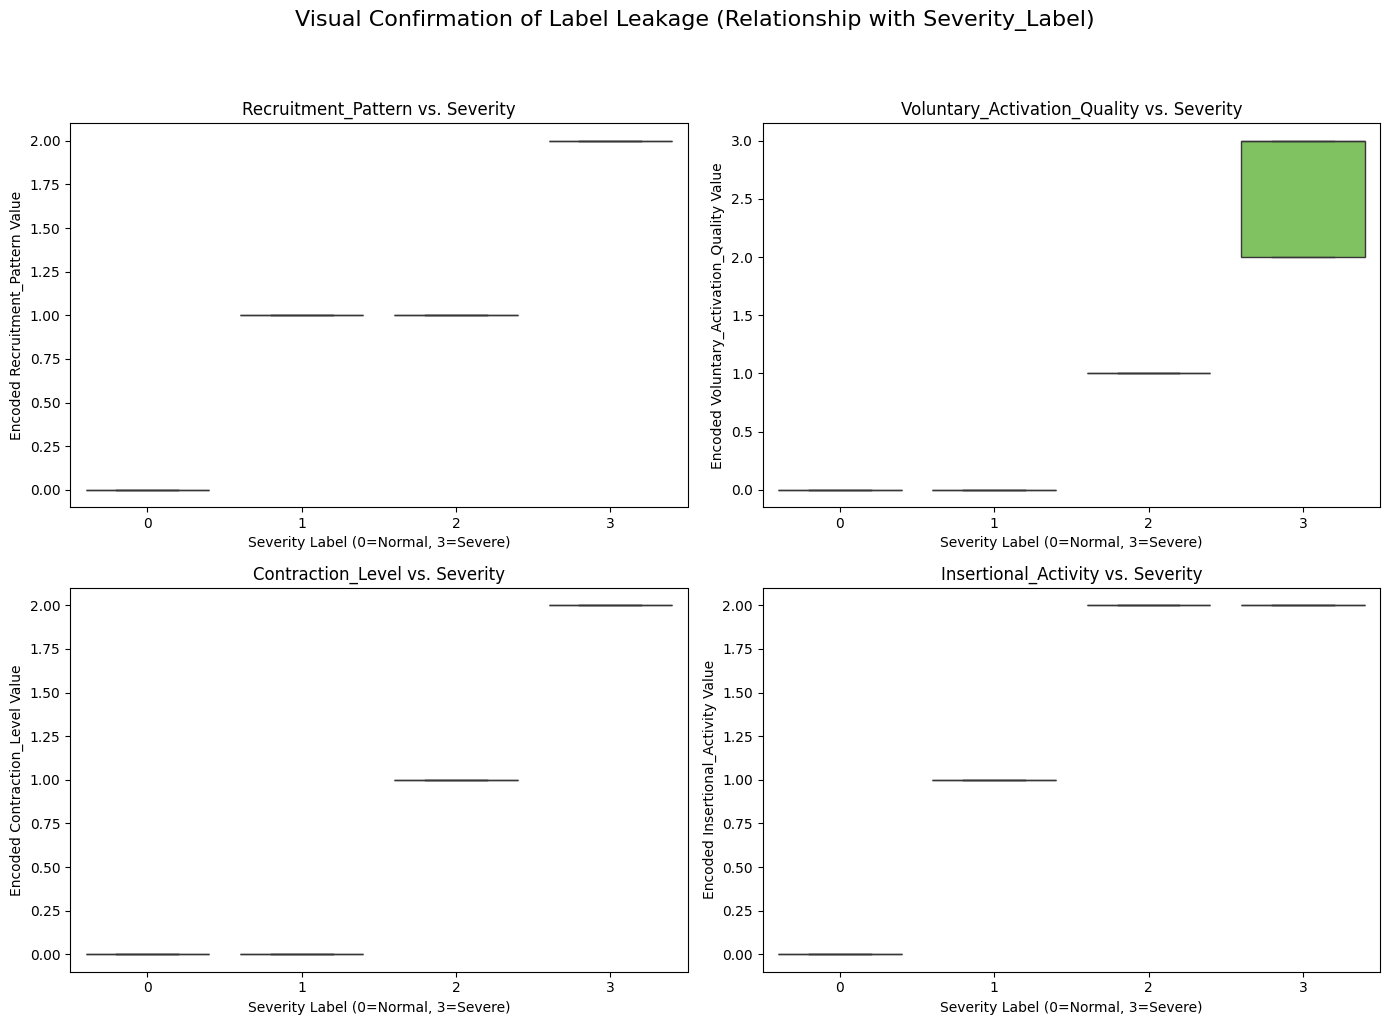

In [239]:
import matplotlib.pyplot as plt
import seaborn as sns

# Potential leakage features to check
leakage_features = [
    'Recruitment_Pattern',
    'Voluntary_Activation_Quality',
    'Contraction_Level',
    'Insertional_Activity'
]

# Set up the figure for all four plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Title the plots clearly
fig.suptitle('Visual Confirmation of Label Leakage (Relationship with Severity_Label)', fontsize=16, y=1.02)

for i, col in enumerate(leakage_features):
    # Plotting the encoded feature values against the target severity
    sns.boxplot(
        x='Severity_Label',
        y=col,
        data=EMG_df,
        ax=axes[i],
        palette='viridis'
    )
    axes[i].set_title(f'{col} vs. Severity', fontsize=12)
    axes[i].set_xlabel('Severity Label (0=Normal, 3=Severe)')
    axes[i].set_ylabel(f'Encoded {col} Value')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [240]:
## REMOVING LEAKAGE FEATURES

leakage_cols_to_remove = [
    'Recruitment_Pattern',
    'Voluntary_Activation_Quality',
    'Contraction_Level',
    'Insertional_Activity'
]

# Create the new, clean DataFrame by dropping the identified columns
# Use a list comprehension and errors='ignore' to prevent errors if a column was already dropped
df_no_leakage_final = EMG_df.drop(
    columns=[col for col in leakage_cols_to_remove if col in EMG_df.columns],
    errors='ignore'
)
print("Leakage features removed. New DataFrame shape:", df_no_leakage_final.shape)

Leakage features removed. New DataFrame shape: (238, 23)


## cross validation with new clean dataset ( after drop the leakage features )

In [241]:
## REDEFINING X and y

# X: Features (drop the target variable from the leakage-free DataFrame)
X_CLEAN = df_no_leakage_final.drop("Severity_Label", axis=1)

# y: Target variable
y_CLEAN = df_no_leakage_final["Severity_Label"]

print("\nFeature matrix (X_CLEAN) created with", X_CLEAN.shape[1], "features.")
print("Target vector (y_CLEAN) created.")


Feature matrix (X_CLEAN) created with 22 features.
Target vector (y_CLEAN) created.


### try multiple k values ( number of features )

In [242]:
# Use the leakage-free data
X = X_CLEAN.copy()
y = y_CLEAN.copy()

n_features = X.shape[1]
print("Number of CLEAN features:", n_features)

# Values of k to try
k_values = [None, 3, 5, 8, 10, 12, 15, 20]
print("k_values:", k_values)

Number of CLEAN features: 22
k_values: [None, 3, 5, 8, 10, 12, 15, 20]


In [243]:
results = []   # to store mean metrics for each (method, k)
classes = np.sort(y.unique())

# store confusion matrices: cm_per[(method, k_display)][fold] = cm
cm_per = {}

methods = ["all", "fisher", "embedded_rf", "forward"]   # 4 strategies

for k in k_values:
    for method in methods:

        # ===== Decide which combinations to run =====
        # Baseline "all features": run only once (when k is None or >= n_features)
        if method == "all":
            if not (k is None or k >= n_features):
                continue  # skip for other k values
            method_name = "All Features"
            k_display = "all"
            use_selection = False

        # All other methods require a valid integer k < n_features
        else:
            if (k is None) or (k >= n_features):
                continue
            k_display = k
            if method == "fisher":
                method_name = "Fisher Score"
            elif method == "embedded_rf":
                method_name = "Embedded RF"
            elif method == "forward":
                method_name = "Forward Selection"
            use_selection = True

        print("\n" + "="*80)
        print(f"Method: {method_name} | k = {k_display}")

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # ---- TEST metrics (validation) ----
        accuracies_ = []
        macro_f1s  = []
        mccs       = []
        ap_severe_list = []

        # ---- TRAIN metrics (overfitting check) ----
        train_accuracies_ = []
        train_macro_f1s  = []
        train_mccs       = []

        selected_features_for_k = None
        cm_per[(method_name, k_display)] = {}

        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
            # --- Split fold ---
            X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # --- Frequency Encoding ---
            for col in freq_cols:
                freq = X_train[col].value_counts(normalize=True)
                X_train[col] = X_train[col].map(freq)
                X_test[col]  = X_test[col].map(freq).fillna(0)

            # ============================
            #  FEATURE SELECTION (by method)
            # ============================
            if not use_selection:
                # baseline: all clean features
                X_train_fs = X_train
                X_test_fs  = X_test
                selected_features = X_train.columns

            else:
                if method == "fisher":
                    # ---- FILTER: Fisher Score ----
                    scores = fisher_score_custom(X_train.values, y_train.values)
                    idx = np.argsort(scores)[::-1][:k]
                    selected_features = X_train.columns[idx]

                elif method == "embedded_rf":
                    # ---- EMBEDDED: RF importance on TRAIN fold ----
                    rf_fs = RandomForestClassifier(
                        n_estimators=200,
                        random_state=42,
                        class_weight='balanced'
                    )
                    rf_fs.fit(X_train, y_train)
                    importances = rf_fs.feature_importances_
                    idx = np.argsort(importances)[::-1][:k]
                    selected_features = X_train.columns[idx]

                elif method == "forward":
                    # ---- WRAPPER: forward selection on TRAIN fold ----
                    base_model = RandomForestClassifier(
                        n_estimators=100,
                        random_state=42,
                        class_weight='balanced'
                    )
                    sfs = SequentialFeatureSelector(
                        base_model,
                        n_features_to_select=k,
                        direction='forward',
                        cv=3,
                        n_jobs=-1
                    )
                    sfs.fit(X_train, y_train)
                    mask = sfs.get_support()
                    selected_features = X_train.columns[mask]

                # apply selected features
                X_train_fs = X_train[selected_features]
                X_test_fs  = X_test[selected_features]

            # save the selected feature names once (first fold)
            if selected_features_for_k is None:
                selected_features_for_k = list(selected_features)

            # --- Model ---
            model = RandomForestClassifier(
                n_estimators=100,
                random_state=42,
                class_weight='balanced'
            )
            model.fit(X_train_fs, y_train)

            # ============================
            #  TRAIN predictions
            # ============================
            y_train_pred = model.predict(X_train_fs)

            train_acc      = accuracy_score(y_train, y_train_pred)
            train_macro_f1 = f1_score(y_train, y_train_pred, average='macro')
            train_mcc      = matthews_corrcoef(y_train, y_train_pred)

            train_accuracies_.append(train_acc)
            train_macro_f1s.append(train_macro_f1)
            train_mccs.append(train_mcc)

            # --- TEST predictions ---
            y_pred  = model.predict(X_test_fs)
            y_proba = model.predict_proba(X_test_fs)

            # --- TEST Metrics ---
            acc      = accuracy_score(y_test, y_pred)
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            mcc      = matthews_corrcoef(y_test, y_pred)

            y_test_severe = (y_test == severe_label).astype(int)
            severe_index  = np.where(model.classes_ == severe_label)[0][0]
            severe_probs  = y_proba[:, severe_index]
            ap_severe     = average_precision_score(y_test_severe, severe_probs)

            accuracies_.append(acc)
            macro_f1s.append(macro_f1)
            mccs.append(mcc)
            ap_severe_list.append(ap_severe)

            # confusion matrix for this fold
            cm = confusion_matrix(y_test, y_pred, labels=classes)
            cm_per[(method_name, k_display)][fold] = cm

            print(
                f"Fold {fold} - "
                f"Train Acc: {train_acc:.3f}, Test Acc: {acc:.3f}, "
                f"Train Macro F1: {train_macro_f1:.3f}, Test Macro F1: {macro_f1:.3f}, "
                f"Train MCC: {train_mcc:.3f}, Test MCC: {mcc:.3f}, "
                f"AP_severe (test): {ap_severe:.3f}"
            )

        # === store mean metrics for this (method, k) ===
        result_row = {
            "method": method_name,
            "k": k_display,

            # TEST (validation) means
            "mean_accuracy":   np.mean(accuracies_),
            "mean_macro_f1":   np.mean(macro_f1s),
            "mean_MCC":        np.mean(mccs),
            "mean_AP_severe":  np.mean(ap_severe_list),

            # TRAIN means (for overfitting check)
            "train_mean_accuracy": np.mean(train_accuracies_),
            "train_mean_macro_f1": np.mean(train_macro_f1s),
            "train_mean_MCC":      np.mean(train_mccs),

            "selected_features": selected_features_for_k
        }

        results.append(result_row)

# === DataFrame with all methods & ks ===
results_df = pd.DataFrame(results)
print("\n\n=== All results (methods comparison) ===")
print(results_df)






Method: All Features | k = all
Fold 1 - Train Acc: 1.000, Test Acc: 0.896, Train Macro F1: 1.000, Test Macro F1: 0.720, Train MCC: 1.000, Test MCC: 0.861, AP_severe (test): 1.000
Fold 2 - Train Acc: 1.000, Test Acc: 0.958, Train Macro F1: 1.000, Test Macro F1: 0.924, Train MCC: 1.000, Test MCC: 0.942, AP_severe (test): 0.911
Fold 3 - Train Acc: 1.000, Test Acc: 0.917, Train Macro F1: 1.000, Test Macro F1: 0.724, Train MCC: 1.000, Test MCC: 0.887, AP_severe (test): 0.817
Fold 4 - Train Acc: 1.000, Test Acc: 0.936, Train Macro F1: 1.000, Test Macro F1: 0.830, Train MCC: 1.000, Test MCC: 0.912, AP_severe (test): 0.893
Fold 5 - Train Acc: 1.000, Test Acc: 0.915, Train Macro F1: 1.000, Test Macro F1: 0.851, Train MCC: 1.000, Test MCC: 0.883, AP_severe (test): 0.967

Method: Fisher Score | k = 3
Fold 1 - Train Acc: 0.942, Test Acc: 0.854, Train Macro F1: 0.934, Test Macro F1: 0.824, Train MCC: 0.921, Test MCC: 0.805, AP_severe (test): 0.911
Fold 2 - Train Acc: 0.942, Test Acc: 0.896, Train 

In [244]:
for row in results:
    print("\n### Method:", row["method"], "| k =", row["k"], "###")
    print("Selected Features:")

    sf = row["selected_features"]
    if isinstance(sf, list):
        for f in sf:
            print(" -", f)
    else:
        print(sf)



### Method: All Features | k = all ###
Selected Features:
 - age
 - sex
 - BMI
 - dominant_side
 - affected_limb
 - limb_temperature_c
 - affected_limb_dominance
 - injury_type
 - time_since_injury_months
 - muscle_name
 - side
 - Electrode_Type
 - Electrode_Depth
 - Positive_Sharp_Waves
 - Fibrillation
 - Fasciculation
 - MUAP_Amplitude (mV)
 - MUAP_Duration (ms)
 - Polyphasic_Units
 - limb_temperature_c_missing
 - time_since_injury_months_missing
 - Electrode_Depth_missing

### Method: Fisher Score | k = 3 ###
Selected Features:
 - Fasciculation
 - Polyphasic_Units
 - Positive_Sharp_Waves

### Method: Embedded RF | k = 3 ###
Selected Features:
 - Fasciculation
 - time_since_injury_months
 - Polyphasic_Units

### Method: Forward Selection | k = 3 ###
Selected Features:
 - injury_type
 - Positive_Sharp_Waves
 - Fasciculation

### Method: Fisher Score | k = 5 ###
Selected Features:
 - Fasciculation
 - Polyphasic_Units
 - Positive_Sharp_Waves
 - Fibrillation
 - MUAP_Amplitude (mV)

### 

### Plotting confusion matrix for each fold

In [245]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    """
    cm: 2D numpy array (confusion matrix)
    class_names: list of class labels to show on axes
    """
    fig, ax = plt.subplots(figsize=(6, 5))

    # show matrix as image
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

    # colorbar on the right
    cbar = ax.figure.colorbar(im, ax=ax)

    # ticks and labels
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)

    # rotate x labels a bit
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # write the numbers inside the boxes
    max_val = cm.max()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            text_color = "white" if value > max_val / 2 else "black"
            ax.text(j, i, format(value, "d"),
                    ha="center", va="center", color=text_color)

    fig.tight_layout()
    plt.show()


====== Fisher Score: k = 3 ======



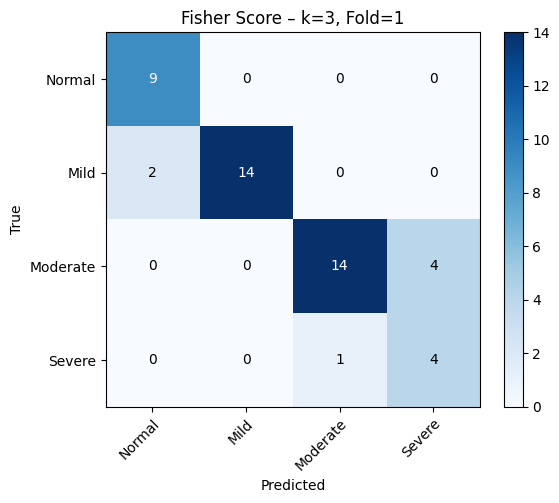

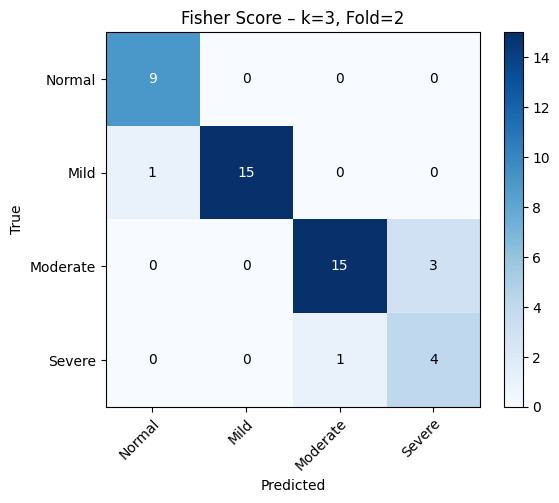

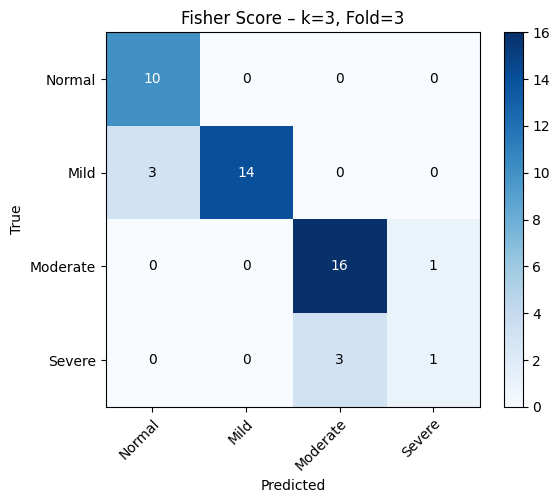

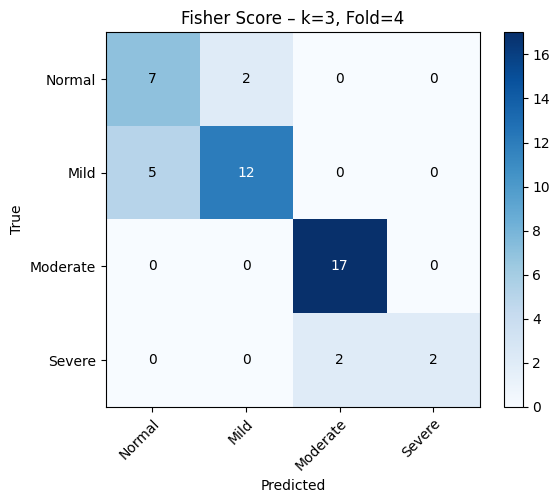

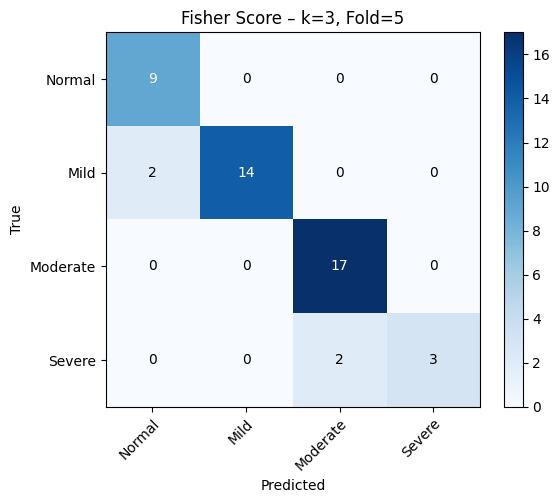


====== Fisher Score: k = 5 ======



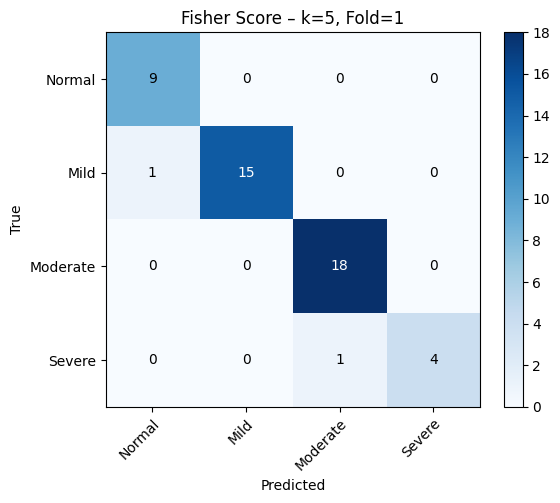

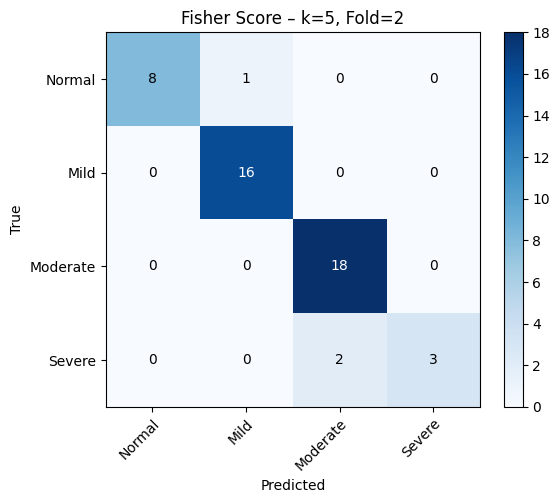

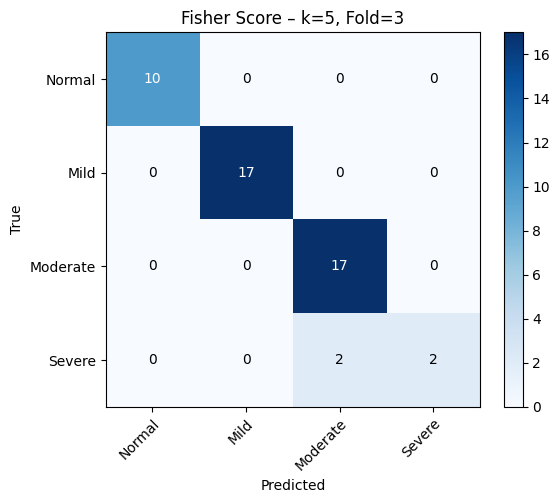

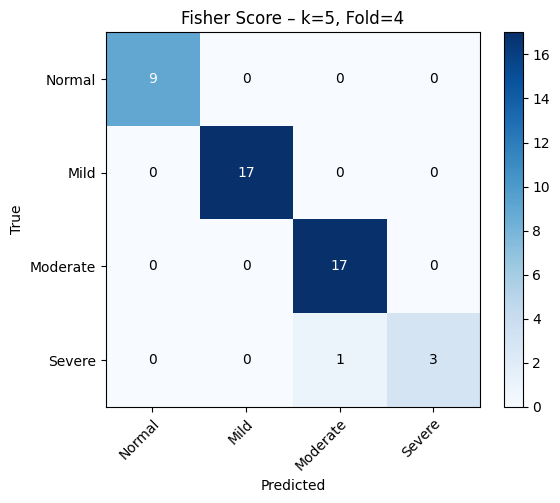

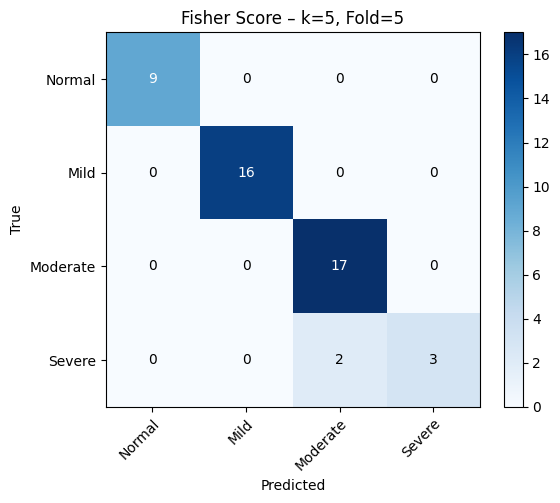


====== Fisher Score: k = 8 ======



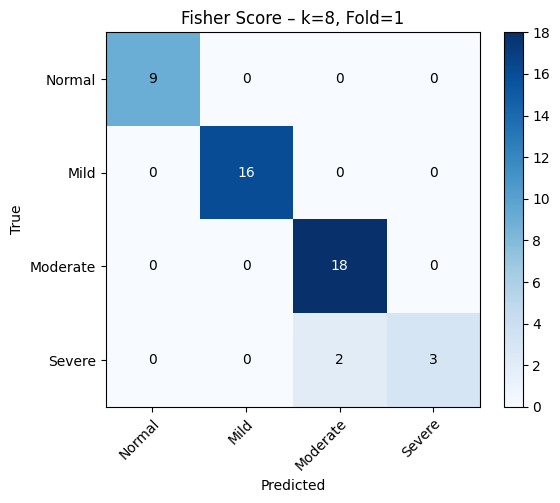

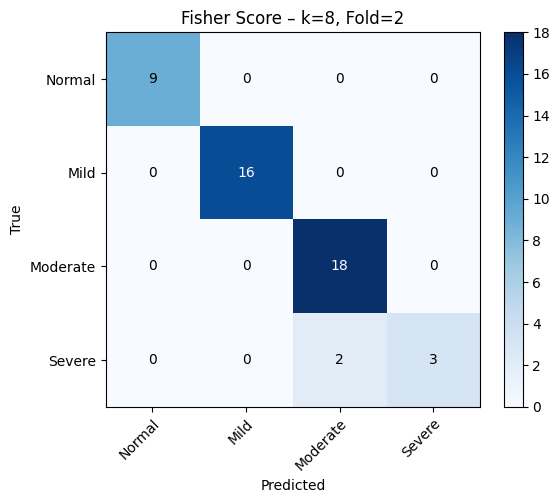

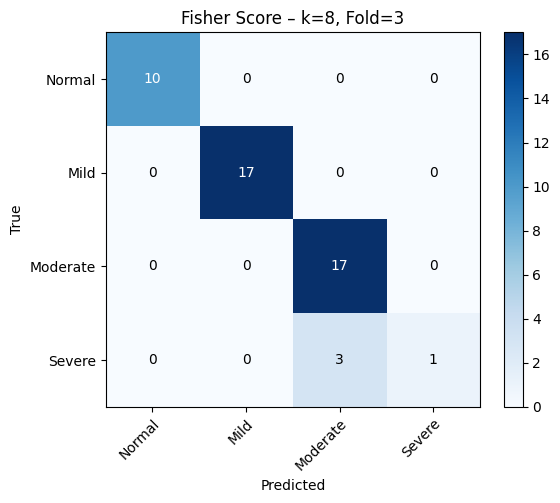

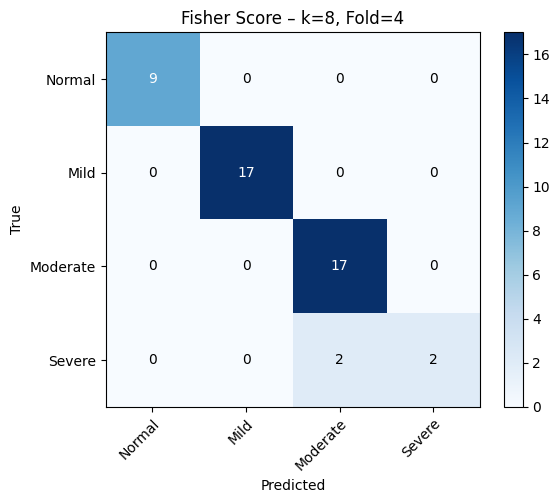

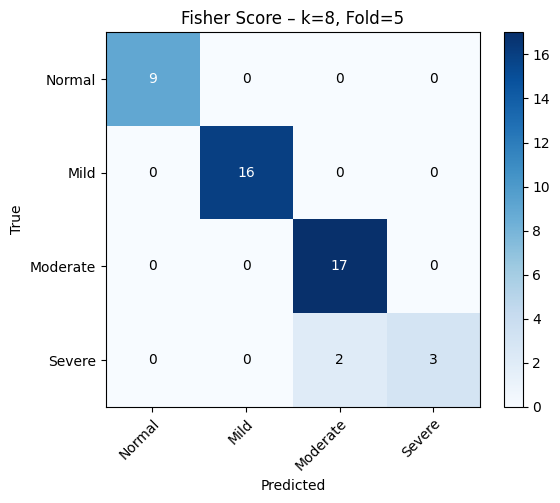


====== Fisher Score: k = 10 ======



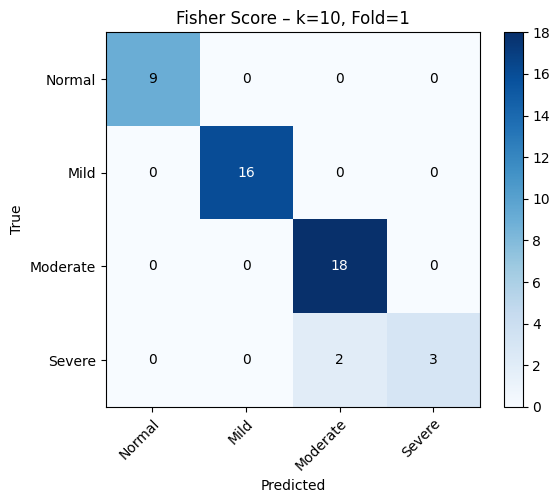

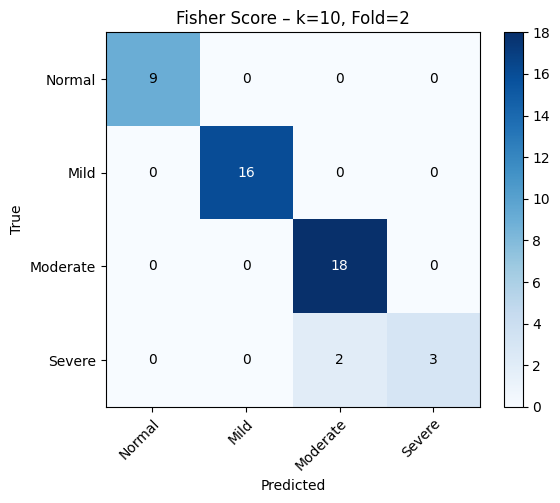

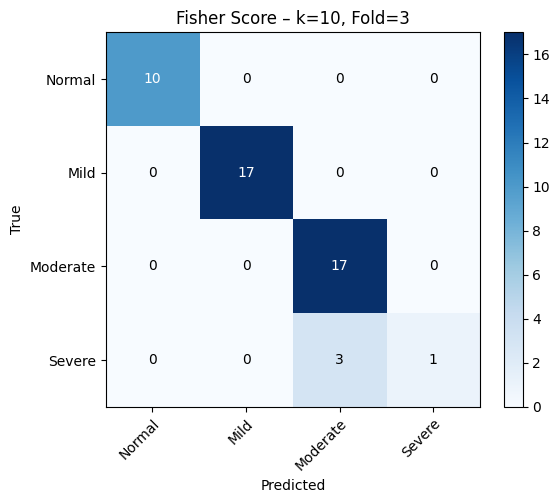

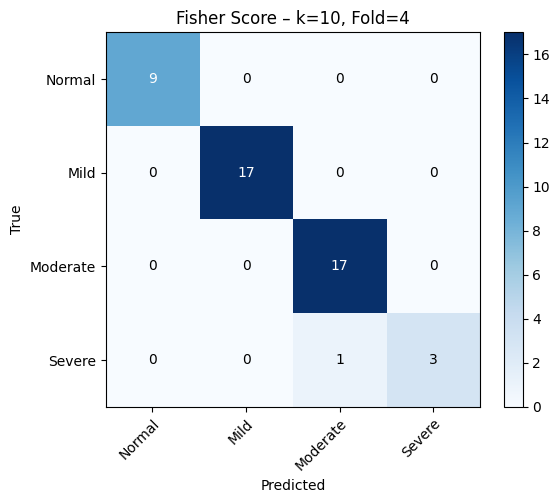

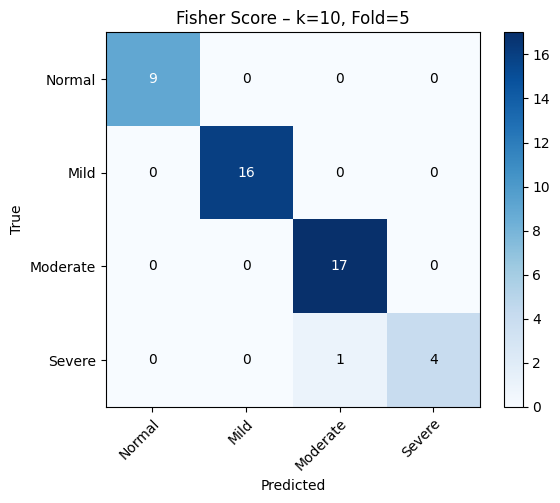


====== Fisher Score: k = 12 ======



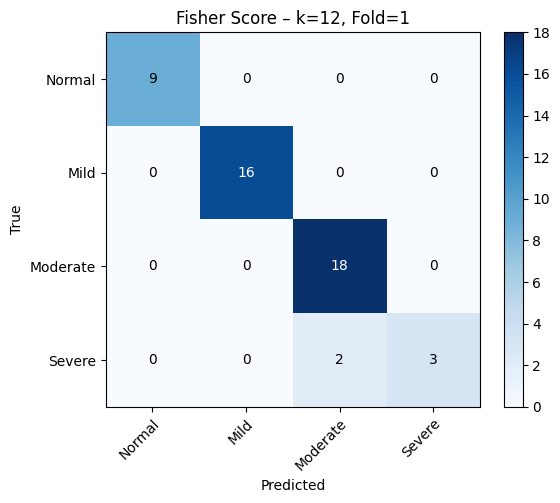

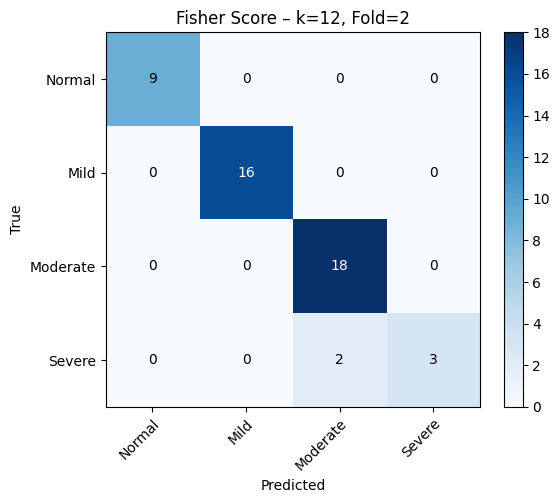

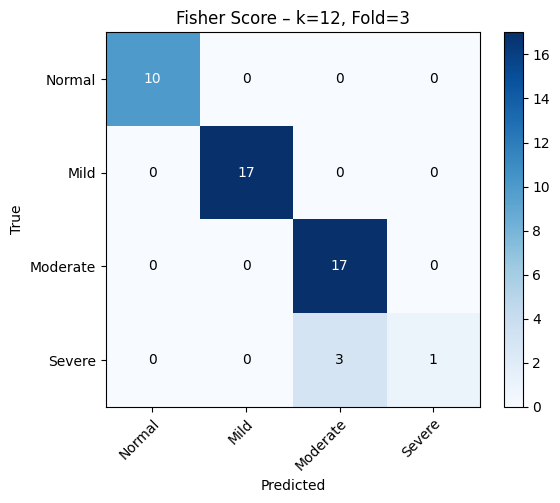

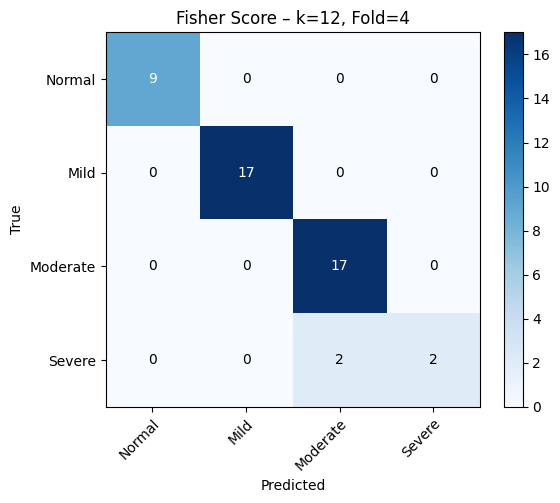

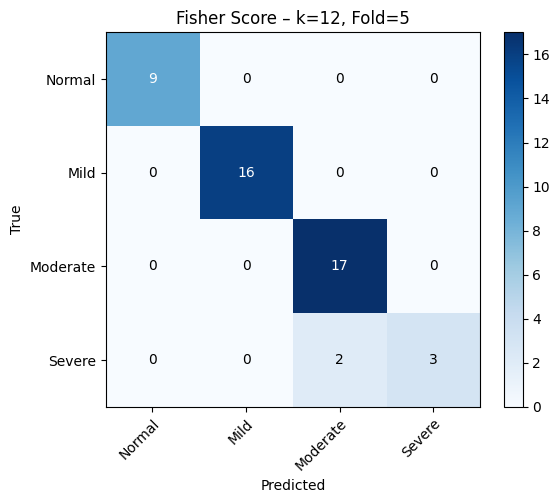


====== Fisher Score: k = 15 ======



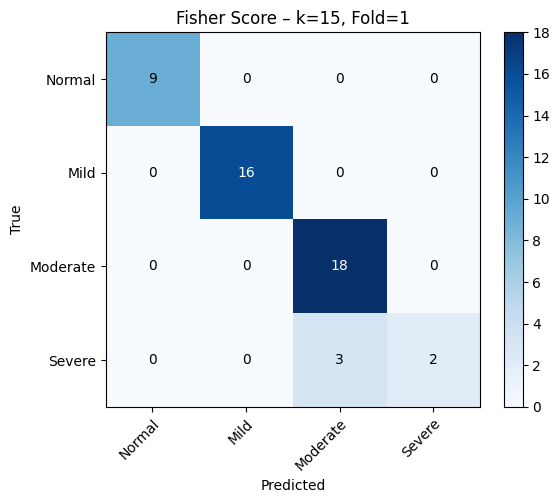

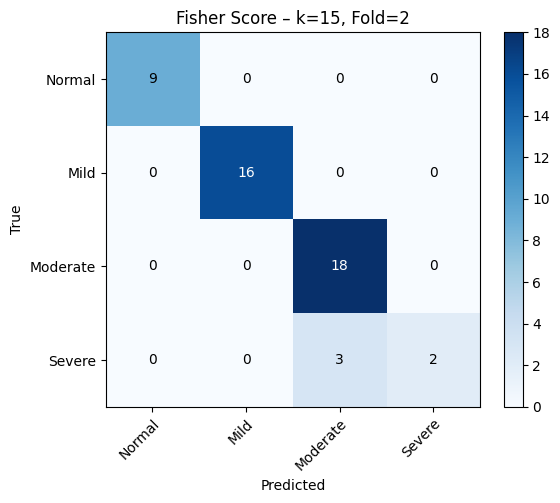

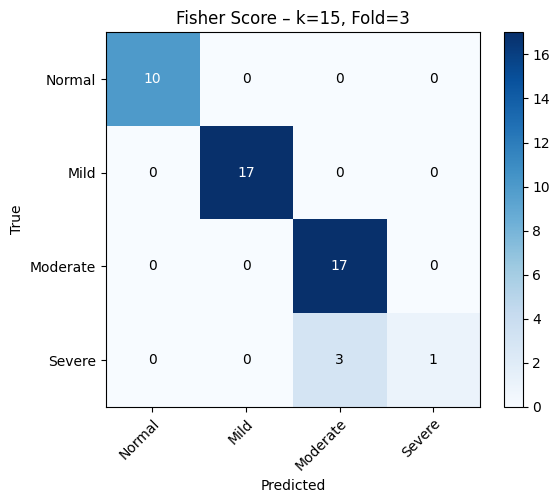

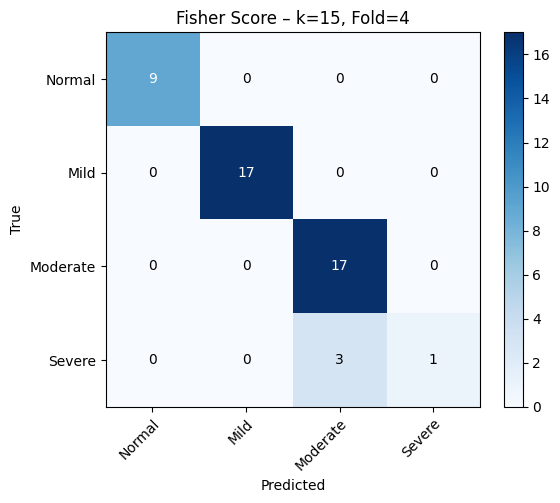

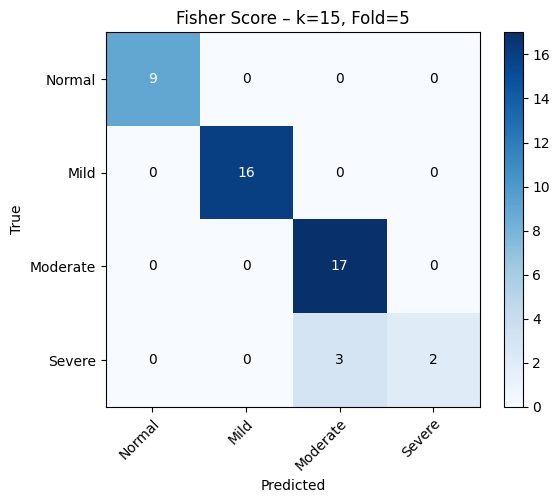


====== Fisher Score: k = 20 ======



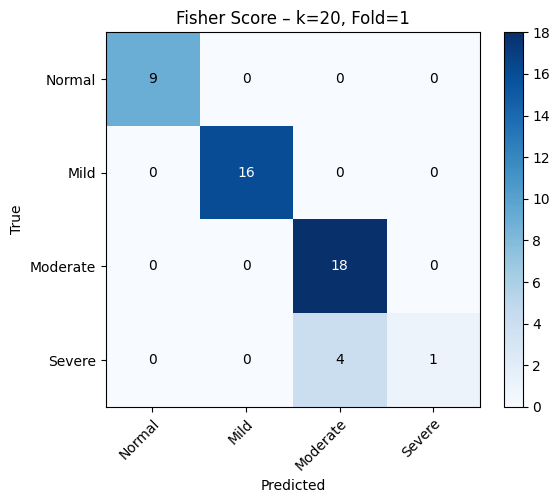

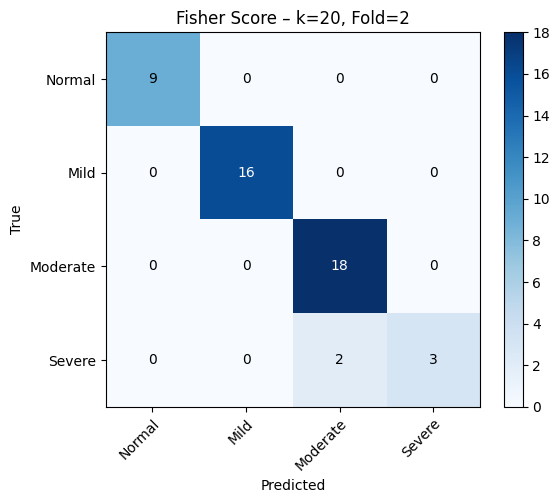

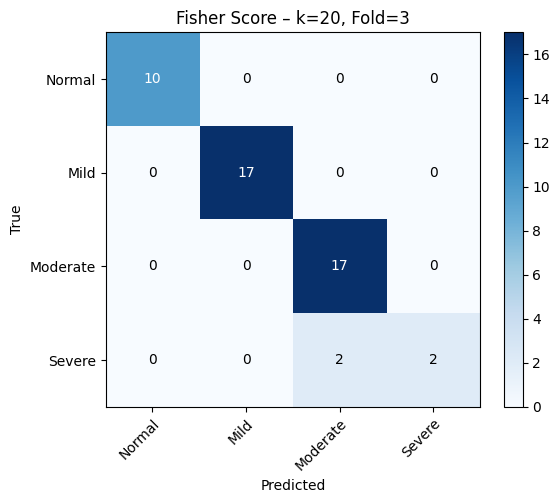

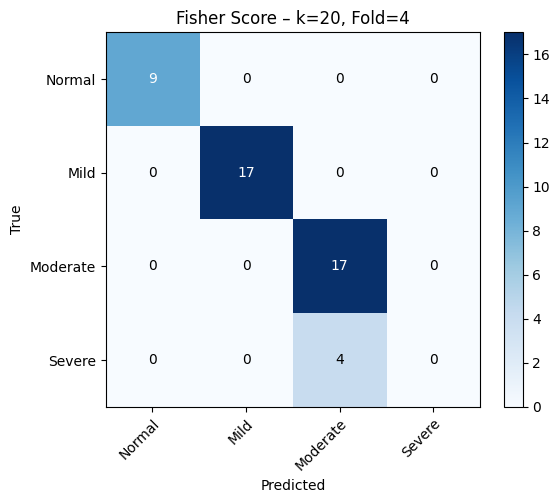

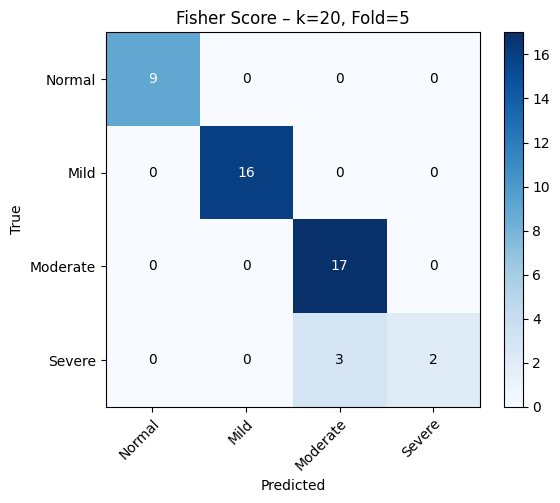

In [246]:
class_names = ["Normal", "Mild", "Moderate", "Severe"]

for (method_name, k_display), folds_dict in cm_per.items():
    if method_name != "Fisher Score":
        continue  # skip other methods

    print(f"\n====== Fisher Score: k = {k_display} ======\n")
    for fold, cm in folds_dict.items():
        plot_confusion_matrix(
            cm,
            class_names=class_names,
            title=f"Fisher Score – k={k_display}, Fold={fold}"
        )



### aggregated (overall) confusion matrix

In [247]:
import numpy as np

def get_aggregated_confusion_matrix(cm_dict_for_k):
    """
    cm_dict_for_k = cm_per_k_fold[k_display]
    returns the sum of all fold confusion matrices
    """
    cms = list(cm_dict_for_k.values())       # [cm1, cm2, cm3, cm4, cm5]
    agg = np.sum(cms, axis=0)                # element-wise sum
    return agg


Fisher rows found:
           method   k
1   Fisher Score   3
4   Fisher Score   5
7   Fisher Score   8
10  Fisher Score  10
13  Fisher Score  12
16  Fisher Score  15
19  Fisher Score  20 


Plotting Fisher Score aggregated confusion matrix for k = 3


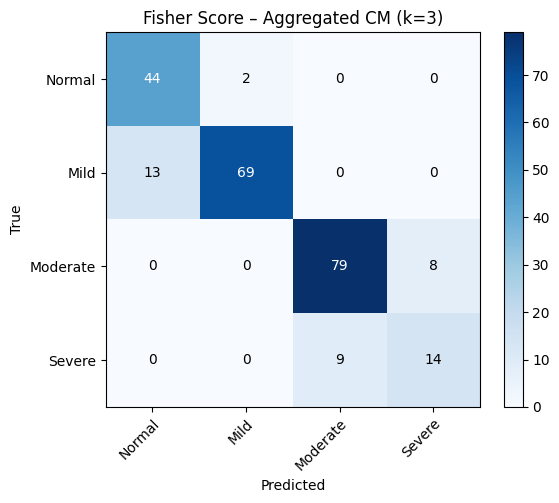


Plotting Fisher Score aggregated confusion matrix for k = 5


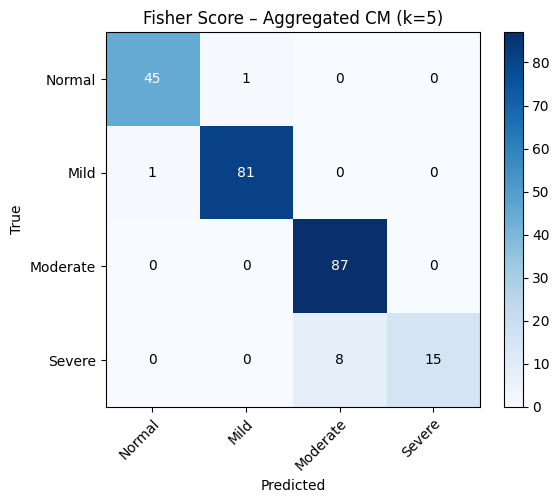


Plotting Fisher Score aggregated confusion matrix for k = 8


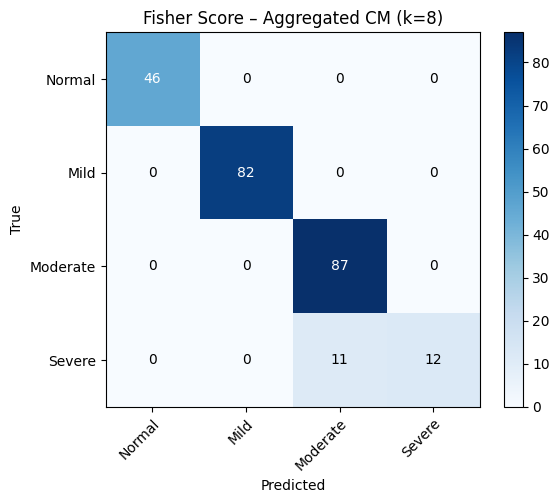


Plotting Fisher Score aggregated confusion matrix for k = 10


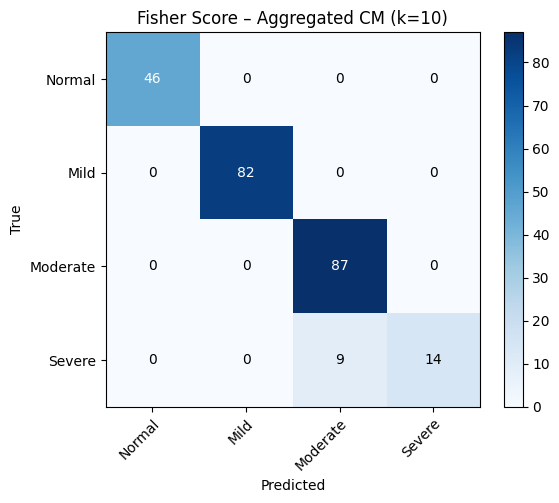


Plotting Fisher Score aggregated confusion matrix for k = 12


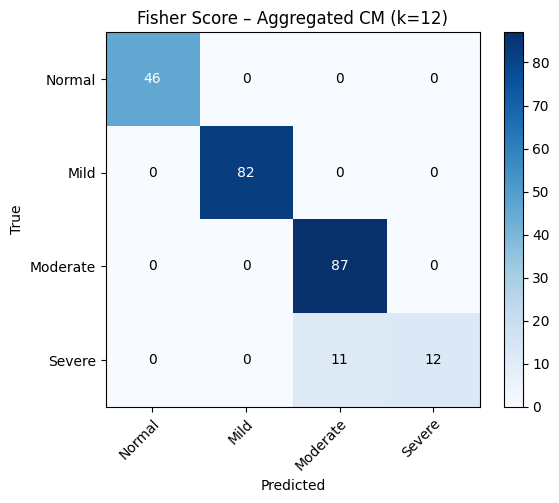


Plotting Fisher Score aggregated confusion matrix for k = 15


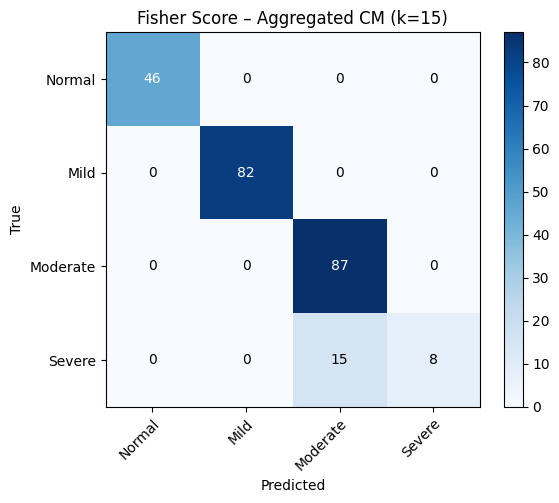


Plotting Fisher Score aggregated confusion matrix for k = 20


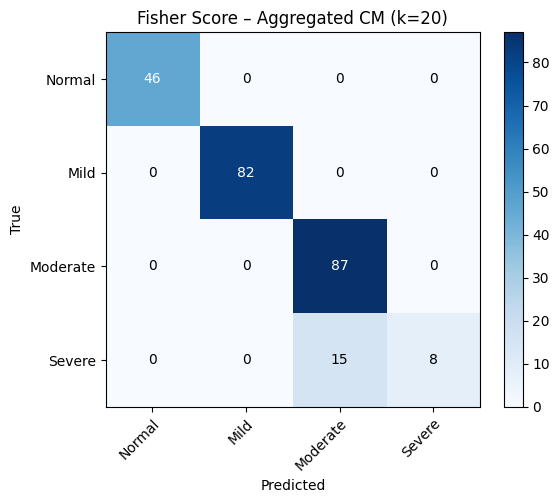

In [248]:
# ===========================
# Plot aggregated CM for ALL Fisher Score k values
# ===========================

class_names = ["Normal", "Mild", "Moderate", "Severe"]

# Filter results_df to only keep Fisher Score rows
fisher_rows = results_df[results_df["method"] == "Fisher Score"]

print("Fisher rows found:\n", fisher_rows[["method", "k"]], "\n")

for idx, row in fisher_rows.iterrows():

    method_name = row["method"]        # "Fisher Score"
    k_display   = row["k"]             # 3, 5, 8, 10, 12, ...

    print(f"\n==============================")
    print(f"Plotting Fisher Score aggregated confusion matrix for k = {k_display}")
    print("==============================")

    # Get all 5 fold confusion matrices
    cm_dict_for_k = cm_per[(method_name, k_display)]

    # Aggregate (sum)
    cm_overall = get_aggregated_confusion_matrix(cm_dict_for_k)

    # Plot
    plot_confusion_matrix(
        cm_overall,
        class_names,
        title=f"Fisher Score – Aggregated CM (k={k_display})"
    )



### overfitting cheking

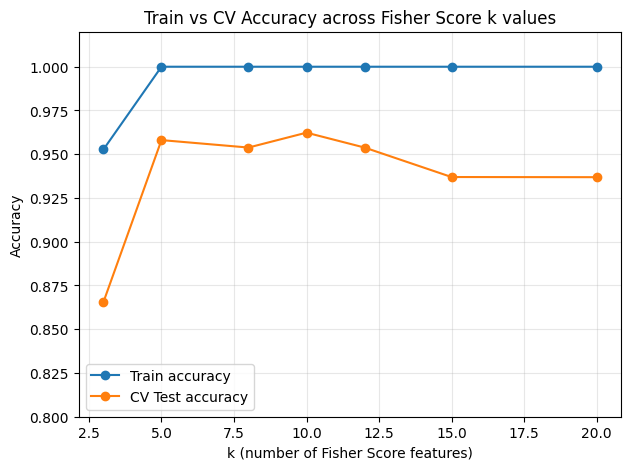

In [249]:
import matplotlib.pyplot as plt

# Filter only Fisher Score rows
fisher_df = results_df[results_df["method"] == "Fisher Score"].copy()

# Ensure k is numeric (not 'all')
fisher_df = fisher_df[fisher_df["k"] != "all"]

x_labels = fisher_df["k"].astype(int)

plt.figure(figsize=(7,5))
plt.plot(x_labels, fisher_df["train_mean_accuracy"], marker="o", label="Train accuracy")
plt.plot(x_labels, fisher_df["mean_accuracy"], marker="o", label="CV Test accuracy")

plt.xlabel("k (number of Fisher Score features)")
plt.ylabel("Accuracy")
plt.title("Train vs CV Accuracy across Fisher Score k values")
plt.ylim(0.8, 1.02)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()



# Model Implementation with 8 features

In [250]:
# Final Fisher Score features for k = 8
final_features = [
    "Fasciculation",
    "Polyphasic_Units",
    "Positive_Sharp_Waves",
    "Fibrillation",
    "MUAP_Amplitude (mV)",
    "MUAP_Duration (ms)",
    "time_since_injury_months",
    "injury_type"
]

# Make sure we're only using these columns from X
X_final = X[final_features].copy()
# keep only the ones that still exist in X_final
freq_cols_final = [c for c in freq_cols if c in X_final.columns]



print("Final X shape:", X_final.shape)
print("Final features:", list(X_final.columns))


print("Frequency-encoded columns in final model:", freq_cols_final)

Final X shape: (238, 8)
Final features: ['Fasciculation', 'Polyphasic_Units', 'Positive_Sharp_Waves', 'Fibrillation', 'MUAP_Amplitude (mV)', 'MUAP_Duration (ms)', 'time_since_injury_months', 'injury_type']
Frequency-encoded columns in final model: ['injury_type']


In [251]:
accuracies        = []   # Test
macro_f1s         = []   # Test
macro_precisions  = []   # Test
macro_recalls     = []   # Test
mccs              = []   # Test
ap_severe_ls      = []   # Test

# NEW: lists for TRAIN metrics
train_accuracies  = []
train_macro_f1s   = []
train_mccs        = []

cm_per_fold = {}   # to store confusion matrices per fold (TEST)

for fold, (train_idx, test_idx) in enumerate(skf.split(X_final, y), start=1):
    # ----- Split data -----
    X_train = X_final.iloc[train_idx].copy()
    X_test  = X_final.iloc[test_idx].copy()
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]

    # ----- Frequency Encoding -----
    for col in freq_cols_final:
        freq = X_train[col].value_counts(normalize=True)
        X_train[col] = X_train[col].map(freq)
        X_test[col]  = X_test[col].map(freq).fillna(0)

    # ----- Model -----
    model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced'
    )
    model.fit(X_train, y_train)

    # ===== TRAIN predictions & metrics =====
    y_pred_train = model.predict(X_train)

    train_acc      = accuracy_score(y_train, y_pred_train)
    train_macro_f1 = f1_score(y_train, y_pred_train, average='macro')
    train_mcc      = matthews_corrcoef(y_train, y_pred_train)

    train_accuracies.append(train_acc)
    train_macro_f1s.append(train_macro_f1)
    train_mccs.append(train_mcc)

    # ===== TEST predictions & metrics =====
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    acc      = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    mcc      = matthews_corrcoef(y_test, y_pred)

    macro_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    macro_recall    = recall_score(y_test, y_pred, average='macro', zero_division=0)

    # AUC-PR for Severe class (TEST)
    y_test_severe = (y_test == severe_label).astype(int)
    severe_index  = np.where(model.classes_ == severe_label)[0][0]
    severe_probs  = y_proba[:, severe_index]
    ap_severe     = average_precision_score(y_test_severe, severe_probs)

    accuracies.append(acc)
    macro_f1s.append(macro_f1)
    mccs.append(mcc)
    macro_precisions.append(macro_precision)
    macro_recalls.append(macro_recall)
    ap_severe_ls.append(ap_severe)

    # Confusion matrix (TEST)
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    cm_per_fold[fold] = cm

    # ===== Fold summary (like your friend's print) =====
    print(
        f"Fold {fold} - "
        f"Train Acc: {train_acc:.3f}, "
        f"Test Acc: {acc:.3f}, "
        f"Train F1: {train_macro_f1:.3f}, "
        f"Test F1: {macro_f1:.3f}, "
        f"Train MCC: {train_mcc:.3f}, "
        f"Test MCC: {mcc:.3f}, "
        f"AP_severe (test): {ap_severe:.3f}"
    )

# ===== Final averaged metrics =====
print("\n===== FINAL 5-fold CV (Tuned RF, Fisher k=8) =====")
print("Mean Train Accuracy: ", np.mean(train_accuracies))
print("Mean Test  Accuracy: ", np.mean(accuracies))
print("Mean Train Macro F1: ", np.mean(train_macro_f1s))
print("Mean Test  Macro F1: ", np.mean(macro_f1s))
print("Mean Train MCC:      ", np.mean(train_mccs))
print("Mean Test  MCC:      ", np.mean(mccs))
print("Mean Test Precision: ", np.mean(macro_precisions))
print("Mean Test Recall:    ", np.mean(macro_recalls))
print("Mean Test AP_severe: ", np.mean(ap_severe_ls))



Fold 1 - Train Acc: 1.000, Test Acc: 0.958, Train F1: 1.000, Test F1: 0.924, Train MCC: 1.000, Test MCC: 0.942, AP_severe (test): 0.967
Fold 2 - Train Acc: 1.000, Test Acc: 0.958, Train F1: 1.000, Test F1: 0.924, Train MCC: 1.000, Test MCC: 0.942, AP_severe (test): 0.891
Fold 3 - Train Acc: 1.000, Test Acc: 0.938, Train F1: 1.000, Test F1: 0.830, Train MCC: 1.000, Test MCC: 0.914, AP_severe (test): 0.707
Fold 4 - Train Acc: 1.000, Test Acc: 0.957, Train F1: 1.000, Test F1: 0.903, Train MCC: 1.000, Test MCC: 0.940, AP_severe (test): 1.000
Fold 5 - Train Acc: 1.000, Test Acc: 0.957, Train F1: 1.000, Test F1: 0.924, Train MCC: 1.000, Test MCC: 0.941, AP_severe (test): 1.000

===== FINAL 5-fold CV (Tuned RF, Fisher k=8) =====
Mean Train Accuracy:  1.0
Mean Test  Accuracy:  0.9538120567375887
Mean Train Macro F1:  1.0
Mean Test  Macro F1:  0.9009605658289868
Mean Train MCC:       1.0
Mean Test  MCC:       0.9360304148420223
Mean Test Precision:  0.9719736842105263
Mean Test Recall:     0.87

In [252]:
# ==========================================
#  AGGREGATED CONFUSION MATRIX (PRE-TUNING)
# ==========================================
def get_aggregated_confusion_matrix(cm_dict):
    """
    cm_dict: dictionary {fold_id: confusion_matrix}
    returns: element-wise sum of all confusion matrices
    """
    cms = list(cm_dict.values())
    agg = np.sum(cms, axis=0)
    return agg

cm_overall = get_aggregated_confusion_matrix(cm_per_fold)

print("\n=== Aggregated Confusion Matrix over 5 folds ===")
print(cm_overall)

# ==========================================
#   PER-CLASS METRICS (Accuracy, F1, etc.)
# ==========================================
print("\n===== Per-Class Metrics (averaged across folds) =====\n")

for i, cls in enumerate(classes):
    TP = cm_overall[i, i]
    FN = cm_overall[i, :].sum() - TP
    FP = cm_overall[:, i].sum() - TP
    TN = cm_overall.sum() - (TP + FN + FP)

    # Per-class accuracy (one-vs-rest)
    acc = (TP + TN) / (TP + TN + FP + FN)

    # Precision, Recall, F1
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1        = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Class: {cls}")
    print(f"   Accuracy:  {acc:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-score:  {f1:.4f}\n")



=== Aggregated Confusion Matrix over 5 folds ===
[[46  0  0  0]
 [ 0 82  0  0]
 [ 0  0 87  0]
 [ 0  0 11 12]]

===== Per-Class Metrics (averaged across folds) =====

Class: 0
   Accuracy:  1.0000
   Precision: 1.0000
   Recall:    1.0000
   F1-score:  1.0000

Class: 1
   Accuracy:  1.0000
   Precision: 1.0000
   Recall:    1.0000
   F1-score:  1.0000

Class: 2
   Accuracy:  0.9538
   Precision: 0.8878
   Recall:    1.0000
   F1-score:  0.9405

Class: 3
   Accuracy:  0.9538
   Precision: 1.0000
   Recall:    0.5217
   F1-score:  0.6857



### hyperparameter tuning for RandomForest with k = 8

In [253]:
# We will use X_final (only the 8 Fisher features) and y
# And freq_cols_final, severe_label, classes that we already defined

# ------------ regularized search space ------------
param_grid = {
    "n_estimators":      [100, 200],      # number of trees
    "max_depth":         [None, 10, 20],
    "max_features":      ["sqrt", "log2", 0.5],
    "min_samples_split": [2, 5],
    "min_samples_leaf":  [1, 2],
}

# All combinations
keys = list(param_grid.keys())
param_combos = list(product(*param_grid.values()))
print("Total combinations:", len(param_combos))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tuning_rows = []

for combo in param_combos:
    params = dict(zip(keys, combo))
    print("\nTesting params:", params)

    fold_macro_f1 = []
    fold_ap_severe = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_final, y), start=1):
        # ----- Split -----
        X_train = X_final.iloc[train_idx].copy()
        X_test  = X_final.iloc[test_idx].copy()
        y_train = y.iloc[train_idx]
        y_test  = y.iloc[test_idx]

        # ----- Frequency Encoding -----
        for col in freq_cols_final:
            freq = X_train[col].value_counts(normalize=True)
            X_train[col] = X_train[col].map(freq)
            X_test[col]  = X_test[col].map(freq).fillna(0)

        # ----- Model with current params -----
        model = RandomForestClassifier(
            n_estimators=params["n_estimators"],
            max_depth=params["max_depth"],
            max_features=params["max_features"],
            min_samples_split=params["min_samples_split"],
            min_samples_leaf=params["min_samples_leaf"],
            class_weight='balanced',   # keep class_weight to handle imbalance
            random_state=42,
        )
        model.fit(X_train, y_train)

        # ----- TEST metrics -----
        y_pred  = model.predict(X_test)
        y_proba = model.predict_proba(X_test)

        macro_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

        # AP for severe
        y_test_severe = (y_test == severe_label).astype(int)
        severe_index  = np.where(model.classes_ == severe_label)[0][0]
        severe_probs  = y_proba[:, severe_index]
        ap_severe     = average_precision_score(y_test_severe, severe_probs)

        fold_macro_f1.append(macro_f1)
        fold_ap_severe.append(ap_severe)

    # mean scores for this param combo
    row = {
        **params,
        "mean_macro_f1": np.mean(fold_macro_f1),
        "mean_AP_severe": np.mean(fold_ap_severe),
    }
    tuning_rows.append(row)
    print("  -> mean_macro_f1 = %.4f, mean_AP_severe = %.4f" %
          (row["mean_macro_f1"], row["mean_AP_severe"]))

# Put all tuning results into a DataFrame
tuning_df = pd.DataFrame(tuning_rows)
print("\n=== Hyperparameter tuning results (sorted by Macro F1) ===")
tuning_df = tuning_df.sort_values(by="mean_macro_f1", ascending=False)
print(tuning_df.head(10))



Total combinations: 72

Testing params: {'n_estimators': 100, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1}
  -> mean_macro_f1 = 0.9010, mean_AP_severe = 0.9129

Testing params: {'n_estimators': 100, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 2}
  -> mean_macro_f1 = 0.8988, mean_AP_severe = 0.8457

Testing params: {'n_estimators': 100, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 1}
  -> mean_macro_f1 = 0.9097, mean_AP_severe = 0.9032

Testing params: {'n_estimators': 100, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 2}
  -> mean_macro_f1 = 0.9145, mean_AP_severe = 0.8395

Testing params: {'n_estimators': 100, 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 1}
  -> mean_macro_f1 = 0.9429, mean_AP_severe = 0.9043

Testing params: {'n_estimators': 100, 'max_depth': None, 'max_feat

In [254]:
#the best parameter from the search space
best_params = {
    "n_estimators": 100,
    "max_depth": 20,
    "max_features": "log2",
    "min_samples_split": 5,
    "min_samples_leaf": 1,
}
print("Chosen best_params:", best_params)


Chosen best_params: {'n_estimators': 100, 'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 1}


In [255]:
# Lists for TEST metrics
accuracies        = []
macro_f1s         = []
macro_precisions  = []
macro_recalls     = []
mccs              = []
ap_severe_ls      = []

# Lists for TRAIN metrics (for overfitting check)
train_accuracies   = []
train_macro_f1s    = []
train_macro_precs  = []
train_macro_recalls = []
train_mccs         = []

cm_per_fold = {}   # to store confusion matrices per fold (TEST)

for fold, (train_idx, test_idx) in enumerate(skf.split(X_final, y), start=1):
    # ----- Split data -----
    X_train = X_final.iloc[train_idx].copy()
    X_test  = X_final.iloc[test_idx].copy()
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]

    # ----- Frequency Encoding -----
    for col in freq_cols_final:
        freq = X_train[col].value_counts(normalize=True)
        X_train[col] = X_train[col].map(freq)
        X_test[col]  = X_test[col].map(freq).fillna(0)

    # ----- Tuned Model -----
    model = RandomForestClassifier(
        n_estimators      = best_params['n_estimators'],
        max_depth         = best_params['max_depth'],
        max_features      = best_params['max_features'],
        min_samples_split = best_params['min_samples_split'],
        min_samples_leaf  = best_params['min_samples_leaf'],
        random_state      = 42,
        class_weight      = 'balanced'
    )

    model.fit(X_train, y_train)

    # ============ TRAIN predictions ============
    y_train_pred = model.predict(X_train)

    train_acc      = accuracy_score(y_train, y_train_pred)
    train_macro_f1 = f1_score(y_train, y_train_pred, average='macro')
    train_macro_p  = precision_score(y_train, y_train_pred, average='macro', zero_division=0)
    train_macro_r  = recall_score(y_train, y_train_pred, average='macro', zero_division=0)
    train_mcc      = matthews_corrcoef(y_train, y_train_pred)

    train_accuracies.append(train_acc)
    train_macro_f1s.append(train_macro_f1)
    train_macro_precs.append(train_macro_p)
    train_macro_recalls.append(train_macro_r)
    train_mccs.append(train_mcc)

    # ============ TEST predictions ============
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # ----- TEST Metrics -----
    acc      = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    macro_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    macro_recall    = recall_score(y_test, y_pred, average='macro', zero_division=0)
    mcc      = matthews_corrcoef(y_test, y_pred)

    # AUC-PR for Severe class
    y_test_severe = (y_test == severe_label).astype(int)
    severe_index  = np.where(model.classes_ == severe_label)[0][0]
    severe_probs  = y_proba[:, severe_index]
    ap_severe     = average_precision_score(y_test_severe, severe_probs)

    # Save TEST metrics
    accuracies.append(acc)
    macro_f1s.append(macro_f1)
    macro_precisions.append(macro_precision)
    macro_recalls.append(macro_recall)
    mccs.append(mcc)
    ap_severe_ls.append(ap_severe)

    # Confusion matrix (TEST)
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    cm_per_fold[fold] = cm

    print(
        f"Fold {fold} - "
        f"Train Acc: {train_acc:.3f}, Test Acc: {acc:.3f}, "
        f"Train F1: {train_macro_f1:.3f}, Test F1: {macro_f1:.3f}, "
        f"Train MCC: {train_mcc:.3f}, Test MCC: {mcc:.3f}, "
        f"AP_severe (test): {ap_severe:.3f}"
    )

# ===== Final averaged metrics (TEST) =====
print("\n===== FINAL 5-fold CV (Tuned RF, Fisher k=8) =====")
print("Mean Train Accuracy:   ", np.mean(train_accuracies))
print("Mean Test  Accuracy:   ", np.mean(accuracies))
print("Mean Train Macro F1:   ", np.mean(train_macro_f1s))
print("Mean Test  Macro F1:   ", np.mean(macro_f1s))
print("Mean Train MCC:        ", np.mean(train_mccs))
print("Mean Test  MCC:        ", np.mean(mccs))
print("Mean Test Precision:   ", np.mean(macro_precisions))
print("Mean Test Recall:      ", np.mean(macro_recalls))
print("Mean Test AP_severe:   ", np.mean(ap_severe_ls))


Fold 1 - Train Acc: 0.995, Test Acc: 0.979, Train F1: 0.991, Test F1: 0.965, Train MCC: 0.993, Test MCC: 0.971, AP_severe (test): 0.967
Fold 2 - Train Acc: 1.000, Test Acc: 0.979, Train F1: 1.000, Test F1: 0.965, Train MCC: 1.000, Test MCC: 0.971, AP_severe (test): 0.883
Fold 3 - Train Acc: 1.000, Test Acc: 0.958, Train F1: 1.000, Test F1: 0.903, Train MCC: 1.000, Test MCC: 0.942, AP_severe (test): 0.707
Fold 4 - Train Acc: 1.000, Test Acc: 0.979, Train F1: 1.000, Test F1: 0.957, Train MCC: 1.000, Test MCC: 0.970, AP_severe (test): 1.000
Fold 5 - Train Acc: 1.000, Test Acc: 0.979, Train F1: 1.000, Test F1: 0.965, Train MCC: 1.000, Test MCC: 0.970, AP_severe (test): 0.943

===== FINAL 5-fold CV (Tuned RF, Fisher k=8) =====
Mean Train Accuracy:    0.9989473684210527
Mean Test  Accuracy:    0.974822695035461
Mean Train Macro F1:    0.998283685144999
Mean Test  Macro F1:    0.9511861861861861
Mean Train MCC:         0.9985086737280385
Mean Test  MCC:         0.9646902571652095
Mean Test Pr

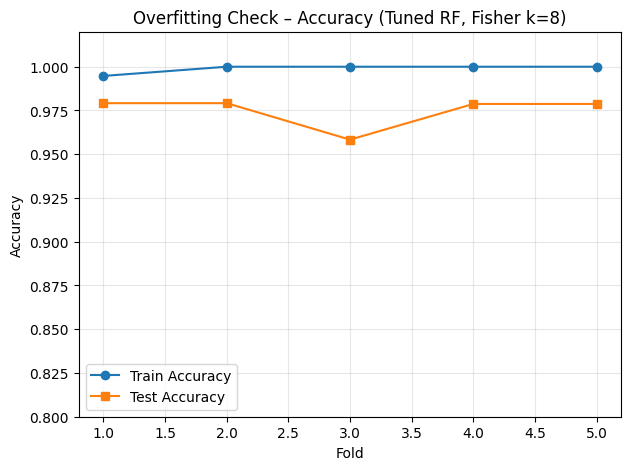

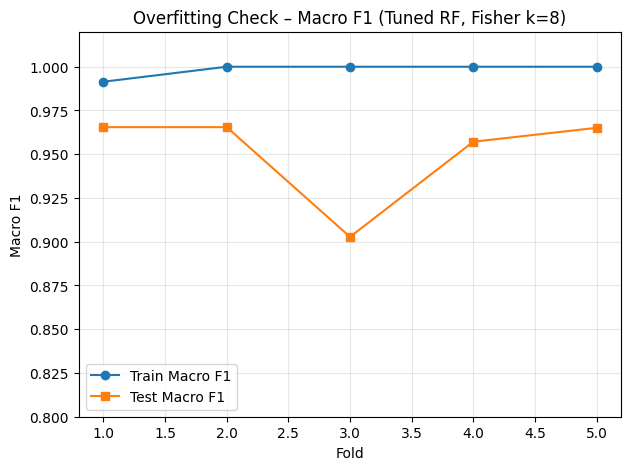

In [256]:
import matplotlib.pyplot as plt
import numpy as np

# number of folds = length of our results lists
fold_ids = np.arange(1, len(accuracies) + 1)

# -------- Accuracy Plot --------
plt.figure(figsize=(7,5))
plt.plot(fold_ids, train_accuracies, marker='o', label="Train Accuracy")
plt.plot(fold_ids, accuracies,      marker='s', label="Test Accuracy")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Overfitting Check – Accuracy (Tuned RF, Fisher k=8)")
plt.grid(True, alpha=0.3)
plt.ylim(0.8, 1.02)
plt.legend()
plt.show()

# -------- Macro F1 Plot --------
plt.figure(figsize=(7,5))
plt.plot(fold_ids, train_macro_f1s, marker='o', label="Train Macro F1")
plt.plot(fold_ids, macro_f1s,       marker='s', label="Test Macro F1")
plt.xlabel("Fold")
plt.ylabel("Macro F1")
plt.title("Overfitting Check – Macro F1 (Tuned RF, Fisher k=8)")
plt.grid(True, alpha=0.3)
plt.ylim(0.8, 1.02)
plt.legend()
plt.show()





=== Confusion Matrix – Fold 1 ===


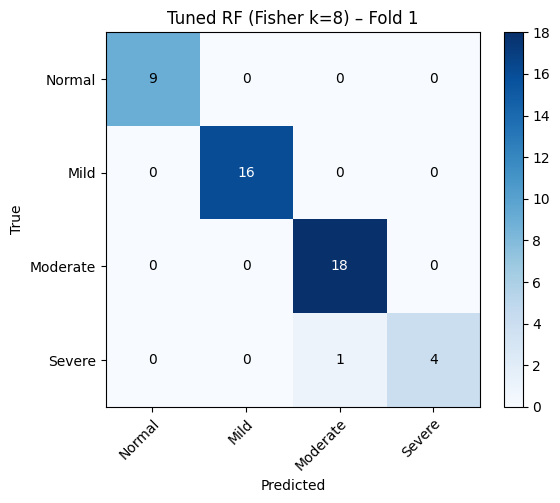


=== Confusion Matrix – Fold 2 ===


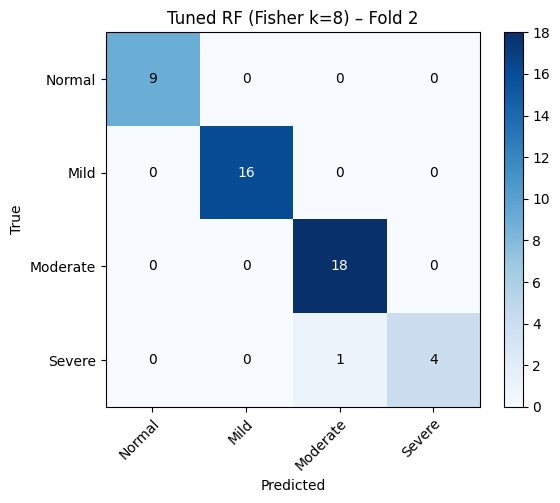


=== Confusion Matrix – Fold 3 ===


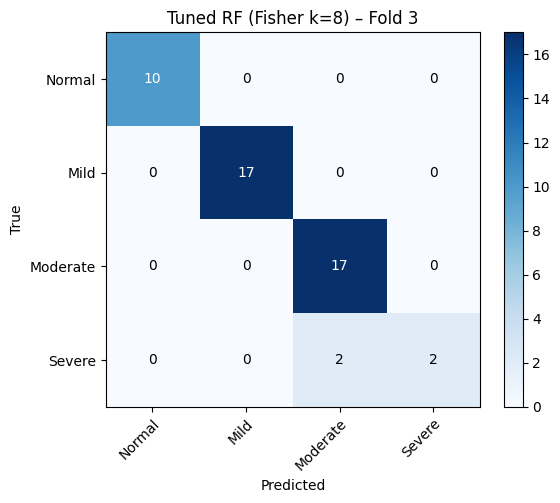


=== Confusion Matrix – Fold 4 ===


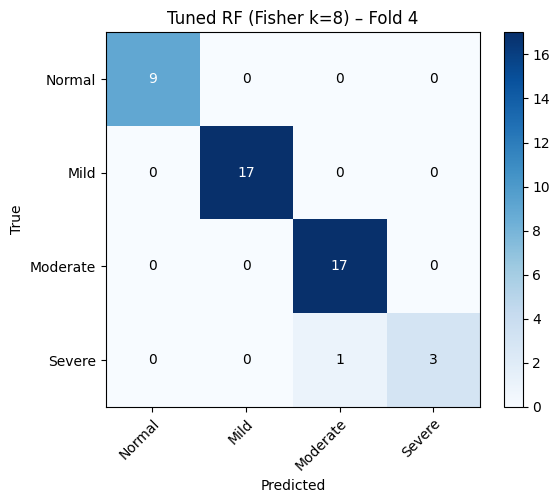


=== Confusion Matrix – Fold 5 ===


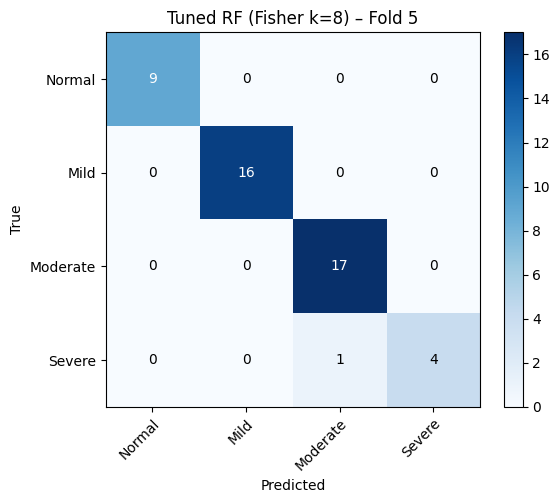

In [257]:
class_names = ["Normal", "Mild", "Moderate", "Severe"]

for fold, cm in cm_per_fold.items():
    print(f"\n=== Confusion Matrix – Fold {fold} ===")
    plot_confusion_matrix(
        cm,
        class_names,
        title=f"Tuned RF (Fisher k=8) – Fold {fold}"
    )



=== Aggregated Confusion Matrix over 5 folds ===
[[46  0  0  0]
 [ 0 82  0  0]
 [ 0  0 87  0]
 [ 0  0  6 17]]


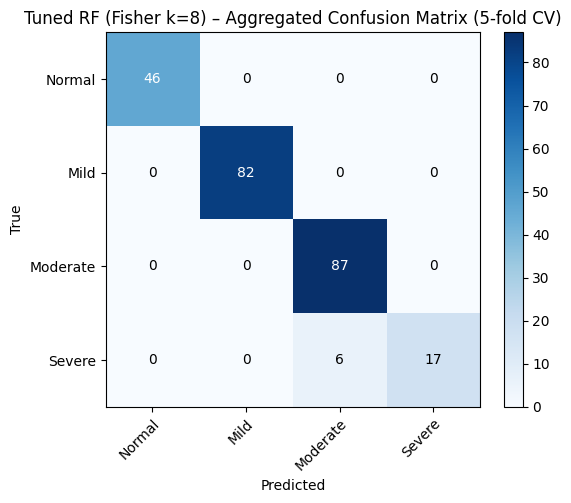

In [258]:
import numpy as np

def get_aggregated_confusion_matrix(cm_dict):
    """
    cm_dict: dictionary {fold_id: confusion_matrix}
    returns the sum of all fold confusion matrices (overall CM)
    """
    cms = list(cm_dict.values())      # [cm1, cm2, cm3, cm4, cm5]
    agg = np.sum(cms, axis=0)         # element-wise sum
    return agg

cm_overall = get_aggregated_confusion_matrix(cm_per_fold)

print("\n=== Aggregated Confusion Matrix over 5 folds ===")
print(cm_overall)

plot_confusion_matrix(
    cm_overall,
    class_names,
    title="Tuned RF (Fisher k=8) – Aggregated Confusion Matrix (5-fold CV)"
)


In [259]:
import numpy as np

cm = cm_overall
class_names = ["Normal", "Mild", "Moderate", "Severe"]
total = cm.sum()

print("===== Per-Class Metrics (averaged across folds) =====\n")

for i, cls in enumerate(class_names):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = total - (TP + FP + FN)

    # Per-class accuracy (one-vs-rest)
    accuracy = (TP + TN) / total

    # Precision, Recall, F1
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1        = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

    print(f"Class: {cls}")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}\n")



===== Per-Class Metrics (averaged across folds) =====

Class: Normal
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-score:  1.0000

Class: Mild
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-score:  1.0000

Class: Moderate
  Accuracy:  0.9748
  Precision: 0.9355
  Recall:    1.0000
  F1-score:  0.9667

Class: Severe
  Accuracy:  0.9748
  Precision: 1.0000
  Recall:    0.7391
  F1-score:  0.8500



#Refit the final model

In [260]:
class SANDSModel:
    """
    SANDSModel
    ----------
    Wrapper around a trained RandomForest model providing:
    - Feature encoding
    - Real-time user input collection
    - Prediction with class probabilities
    """

    def __init__(self, rf_model, feature_order, injury_freq_map, label_map=None):
        # Store trained model + feature metadata
        self.model = rf_model
        self.feature_order = feature_order
        self.injury_freq_map = injury_freq_map

        # Numerical → Severity label mapping
        self.label_map = label_map or {
            0: "Normal",
            1: "Mild",
            2: "Moderate",
            3: "Severe"
        }

        # Ordinal encoding rules for neuromuscular features
        self.neurometric_encoding = {
            "Fasciculation": {
                "Absent": 0, "Present (1+)": 1, "Present (2+)": 2, "Present (3+)": 3
            },
            "Positive_Sharp_Waves": {
                "Absent": 0, "Present (1+)": 1, "Present (2+)": 2, "Present (3+)": 3
            },
            "Fibrillation": {
                "Absent": 0, "Present (1+)": 1, "Present (2+)": 2, "Present (3+)": 3
            }
        }

    # 1) USER INPUT ENCODING (Raw → Numerical → DataFrame)

    def encode_user_input(self, user_input):
        """
        Converts raw user inputs (strings/numbers) into a numerical
        DataFrame matching the trained model's feature order.
        """

        def encode_neuro(feature, value):
            """Apply ordinal encoding to neuromuscular fields."""
            if feature in self.neurometric_encoding:
                return self.neurometric_encoding[feature].get(value, 0)
            return value

        # Neuromuscular ordinal fields
        final = {
            "Fasciculation": encode_neuro("Fasciculation", user_input["Fasciculation"]),
            "Polyphasic_Units": int(user_input["Polyphasic_Units"]),
            "Positive_Sharp_Waves": encode_neuro("Positive_Sharp_Waves", user_input["Positive_Sharp_Waves"]),
            "Fibrillation": encode_neuro("Fibrillation", user_input["Fibrillation"]),

            # Numeric fields
            "MUAP_Amplitude (mV)": float(user_input["MUAP_Amplitude (mV)"]),
            "MUAP_Duration (ms)": float(user_input["MUAP_Duration (ms)"]),
            "time_since_injury_months": float(user_input["time_since_injury_months"]),
        }

        # injury_type: convert from string → frequency using the training map
        inj_raw = user_input["injury_type"]
        inj_freq_value = self.injury_freq_map.get(inj_raw, 0.0)
        final["injury_type"] = inj_freq_value

        import pandas as pd
        df = pd.DataFrame([final])
        return df

    # 2) REAL-TIME USER INPUT COLLECTION (Interactive)

    def realtime_user_input(self):
        """
        Interactive CLI-style questionnaire used to collect user inputs.
        """

        def ask_neuro(feature_name):
            """Prompt user to choose from neuromuscular ordinal options."""
            print(f"\n{feature_name} options:")
            print("  1) Absent")
            print("  2) Present (1+)")
            print("  3) Present (2+)")
            print("  4) Present (3+)")
            while True:
                c = input(f"Choose {feature_name} (1-4): ").strip()
                if c == "1": return "Absent"
                if c == "2": return "Present (1+)"
                if c == "3": return "Present (2+)"
                if c == "4": return "Present (3+)"
                print("Invalid input. Try again.")

        user = {}

        # Collect neuromuscular fields
        user["Fasciculation"] = ask_neuro("Fasciculation")
        user["Positive_Sharp_Waves"] = ask_neuro("Positive_Sharp_Waves")
        user["Fibrillation"] = ask_neuro("Fibrillation")

        # Numeric inputs
        user["Polyphasic_Units"] = input("\nPolyphasic Units: ")
        user["MUAP_Amplitude (mV)"] = input("MUAP Amplitude (mV): ")
        user["MUAP_Duration (ms)"] = input("MUAP Duration (ms): ")
        user["time_since_injury_months"] = input("Time Since Injury (months): ")

        # Categorical input (string, same labels as training)
        user["injury_type"] = input("\nInjury Type (same text as in dataset): ")

        return user

    # 3) ENSURE CORRECT FEATURE ORDER BEFORE SENDING TO MODEL

    def prepare_input(self, df):
        """Reorder dataframe columns to match training order."""
        return df[self.feature_order]

    # 4) TOP-LEVEL PREDICTION FUNCTION (Raw Input → Output)

    def predict_from_user_input(self, raw_user_input):
        """Full pipeline: encode → reorder features → predict."""
        encoded = self.encode_user_input(raw_user_input)
        prepared = self.prepare_input(encoded)
        return self.predict_with_probs(prepared)

    # 5) MODEL PREDICTION + PROBABILITIES

    def predict_with_probs(self, sample_df):
        """
        Returns:
        - predicted severity label
        - confidence score
        - class probability distribution
        """
        import pandas as pd

        # allow passing a Series (e.g., X_all.iloc[0])
        if isinstance(sample_df, pd.Series):
            sample_df = sample_df.to_frame().T

        sample_df = self.prepare_input(sample_df)

        preds = self.model.predict(sample_df)
        probas = self.model.predict_proba(sample_df)[0]
        classes = self.model.classes_

        pred_int = int(preds[0])
        pred_label = self.label_map[pred_int]

        prob_dict = {
            self.label_map[c]: float(p)
            for c, p in zip(classes, probas)
        }

        confidence = float(max(probas))

        # Display prediction summary
        print("\n===== Prediction Result =====")
        print("Predicted Class:", pred_label)
        print(f"Confidence: {confidence*100:.2f}%")

        print("\nClass Probabilities:")
        for cls, p in prob_dict.items():
            print(f"  {cls}: {p*100:.2f}%")

        return pred_label, confidence, prob_dict



In [261]:
# 1) Make a copy of X_final and do frequency encoding on ALL rows
X_all = X_final.copy()
feature_order = list(X_all.columns)

print("X_all shape:", X_all.shape)
print("\nFinal features used for training / feature_order = list(X_all.columns):", list(X_all.columns))

# Build the frequency map for injury_type from the FULL data
freq = X_all["injury_type"].value_counts(normalize=True)
injury_freq_map = freq.to_dict()     # <-- we will give this to SANDSModel

# Apply frequency encoding
X_all["injury_type"] = X_all["injury_type"].map(injury_freq_map).fillna(0)


X_all shape: (238, 8)

Final features used for training / feature_order = list(X_all.columns): ['Fasciculation', 'Polyphasic_Units', 'Positive_Sharp_Waves', 'Fibrillation', 'MUAP_Amplitude (mV)', 'MUAP_Duration (ms)', 'time_since_injury_months', 'injury_type']


In [262]:
# 2) Build the FINAL RandomForest with our tuned hyperparameters
final_model = RandomForestClassifier(
    n_estimators      = best_params['n_estimators'],
    max_depth         = best_params['max_depth'],
    max_features      = best_params['max_features'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf  = best_params['min_samples_leaf'],
    class_weight      = 'balanced',
    random_state      = 42
)

In [263]:
# 3) Train on 100% of the data
final_model.fit(X_all, y)

print("Final model trained on ALL data.")

Final model trained on ALL data.


In [264]:
# Build our wrapper object (SANDS-style)
sands_model = SANDSModel(
    rf_model       = final_model,
    feature_order  = feature_order,
    injury_freq_map= injury_freq_map
)

In [265]:
# Save Final Model & Final Function in same class
import joblib
joblib.dump(sands_model, "sands.pkl")
print("SANDS-style RF model saved as sands.pkl")


SANDS-style RF model saved as sands.pkl


# Test Final Approved Model

In [275]:
import joblib

sands_model = joblib.load("/content/sands.pkl")

raw_user = sands_model.realtime_user_input()
pred, conf, probs = sands_model.predict_from_user_input(raw_user)



Fasciculation options:
  1) Absent
  2) Present (1+)
  3) Present (2+)
  4) Present (3+)
Choose Fasciculation (1-4): 3

Positive_Sharp_Waves options:
  1) Absent
  2) Present (1+)
  3) Present (2+)
  4) Present (3+)
Choose Positive_Sharp_Waves (1-4): 4

Fibrillation options:
  1) Absent
  2) Present (1+)
  3) Present (2+)
  4) Present (3+)
Choose Fibrillation (1-4): 4

Polyphasic Units: 74
MUAP Amplitude (mV): 6.7
MUAP Duration (ms): 13.4
Time Since Injury (months): 10

Injury Type (same text as in dataset): Traumatic – Axonotmesis

===== Prediction Result =====
Predicted Class: Severe
Confidence: 63.59%

Class Probabilities:
  Normal: 0.00%
  Mild: 4.21%
  Moderate: 32.20%
  Severe: 63.59%
